<a href="https://colab.research.google.com/github/idoo25/CloudProject_Unicorn/blob/master/HW3_Unicorn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌿 CloudGarden - Layered Architecture

This notebook is organized in a **Layered Architecture** for maintainability:

| Layer | Section | Description |
|-------|---------|-------------|
| **L1** | Configuration | Package installation, imports, API keys |
| **L2** | Data Access | Firebase operations, server sync |
| **L3** | Business Logic | Data processing, ML models, analytics |
| **L4** | Services | Report microservice |
| **L5** | Presentation | Gradio UI tabs |
| **L6** | Application | App builder and launch |

---

# 📦 LAYER 1: Configuration

# ✅ PIP INSTALL (GLOBAL)

In [ ]:
!pip install -q --upgrade gradio pandas matplotlib python-docx
!pip install -q --upgrade firebase-admin plotly gdown
!pip -q install cerebras-cloud-sdk
!pip -q install -U google-genai
!pip install -q fastapi uvicorn
!pip -q install python-dotenv
!pip -q install gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.0/23.0 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 22.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.1/137.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

# ✅ IMPORTS (GLOBAL)

In [ ]:
import gradio as gr
from transformers import pipeline
import requests
import pandas as pd
import matplotlib.pyplot as plt
#######
# Report Generator with DOCX Export
from cerebras.cloud.sdk import Cerebras
from zoneinfo import ZoneInfo
from datetime import timezone,datetime, timedelta
from docx import Document
import tempfile
import os
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.shared import Inches, Pt, RGBColor
from typing import List, Dict, Tuple, Any, Optional

#Gamification imports
import random

# Firebase imports
import firebase_admin
from firebase_admin import credentials, db

# Additional imports for IoT Dashboard
import warnings
from collections import defaultdict

import gdown
import json

# Plotly imports
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import numpy as np

warnings.filterwarnings('ignore')

#--------RAG & Index-------------#
import re
import json
import time
import math
import random
from collections import Counter, defaultdict
from urllib.parse import quote
# --- Web fetch + HTML parsing ---
from bs4 import BeautifulSoup

# --- NLP (stemming / stopwords) ---
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

stemmer = PorterStemmer()
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))


# --- Chat conversation ---#
from google import genai
from google.genai import types
import re
import gdown


from dotenv import load_dotenv
from io import BytesIO
from fastapi import FastAPI
from fastapi.responses import Response
from pydantic import BaseModel
from cerebras.cloud.sdk import Cerebras


import subprocess
import sys
from google.colab import drive
from fastapi import FastAPI
from pydantic import BaseModel



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# ✅ REPORT SERVICE

In [ ]:
%%writefile report_service.py
from fastapi import FastAPI
from fastapi.responses import Response
from pydantic import BaseModel

import os
import tempfile
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
from typing import List, Dict, Any

import pandas as pd
from docx import Document
from docx.enum.text import WD_ALIGN_PARAGRAPH

from cerebras.cloud.sdk import Cerebras

app = FastAPI(title="Generate Report Microservice (Cerebras + DOCX)")

# -------- API Schema --------
class ReportPayload(BaseModel):
    limit: int
    temperature: List[Dict[str, Any]]
    humidity: List[Dict[str, Any]]
    soil: List[Dict[str, Any]]

@app.get("/health")
def health():
    return {"ok": True}

# -------- Helpers --------
def records_to_df(records: List[Dict[str, Any]]) -> pd.DataFrame:
    if not records:
        return pd.DataFrame(columns=["created_at", "value"])
    df = pd.DataFrame(records)
    if "created_at" not in df.columns or "value" not in df.columns:
        return pd.DataFrame(columns=["created_at", "value"])
    return df

def unify_sensor_dfs(dfs: dict) -> pd.DataFrame:
    def prep(df, col):
        if df is None or df.empty:
            return pd.DataFrame(columns=["timestamp", col])

        out = df.copy()
        if "timestamp" not in out.columns and "created_at" in out.columns:
            out = out.rename(columns={"created_at": "timestamp"})

        if "timestamp" not in out.columns:
            out = out.reset_index().rename(columns={"index": "timestamp"})

        if "timestamp" not in out.columns or "value" not in out.columns:
            return pd.DataFrame(columns=["timestamp", col])

        out = out[["timestamp", "value"]]
        ts = out["timestamp"]

        # numeric timestamp (s/ms) OR datetime string
        if pd.api.types.is_numeric_dtype(ts) or ts.astype(str).str.fullmatch(r"\d+").all():
            ts_num = pd.to_numeric(ts, errors="coerce")
            unit = "ms" if ts_num.dropna().astype(int).astype(str).str.len().median() >= 13 else "s"
            out["timestamp"] = (
                pd.to_datetime(ts_num, errors="coerce", unit=unit, utc=True)
                .dt.tz_convert("Asia/Jerusalem")
                .dt.tz_localize(None)
            )
        else:
            out["timestamp"] = (
                pd.to_datetime(ts, errors="coerce", utc=True)
                .dt.tz_convert("Asia/Jerusalem")
                .dt.tz_localize(None)
            )

        out = out.dropna(subset=["timestamp"])
        out["value"] = pd.to_numeric(out["value"], errors="coerce")
        out = out.dropna(subset=["value"])
        out = out.rename(columns={"value": col})
        return out

    t = prep(dfs.get("temperature"), "temperature")
    h = prep(dfs.get("humidity"), "humidity")
    s = prep(dfs.get("soil"), "soil")

    df = t.merge(h, on="timestamp", how="outer").merge(s, on="timestamp", how="outer")
    df = df.sort_values("timestamp").reset_index(drop=True)
    return df

class AutomatedReportGenerator:
    def __init__(self, cerebras_client, model_name: str):
        self.client = cerebras_client
        self.model_name = model_name

    def generate_daily_report(self, df: pd.DataFrame) -> str:
        if df.empty:
            return "No data available for report."

        try:
            cutoff = df["timestamp"].max() - timedelta(hours=24)
            daily = df[df["timestamp"] > cutoff]
            if daily.empty:
                daily = df.tail(100)
        except Exception:
            daily = df.tail(100)

        stats = {
            "date": daily["timestamp"].max().strftime("%Y-%m-%d"),
            "readings": len(daily),
            "temp_avg": daily["temperature"].mean(),
            "temp_min": daily["temperature"].min(),
            "temp_max": daily["temperature"].max(),
            "humidity_avg": daily["humidity"].mean(),
            "humidity_min": daily["humidity"].min(),
            "humidity_max": daily["humidity"].max(),
            "soil_avg": daily["soil"].mean(),
            "soil_min": daily["soil"].min(),
            "soil_max": daily["soil"].max(),
        }

        prompt = f"""Generate a professional daily plant health report based on this data:

DATE: {stats['date']}
READINGS: {stats['readings']} sensor measurements

ENVIRONMENTAL CONDITIONS:
- Temperature: {stats['temp_avg']:.1f}°C (range: {stats['temp_min']:.1f}-{stats['temp_max']:.1f}°C)
- Humidity: {stats['humidity_avg']:.1f}% (range: {stats['humidity_min']:.1f}-{stats['humidity_max']:.1f}%)
- Soil Moisture: {stats['soil_avg']:.1f}% (range: {stats['soil_min']:.1f}-{stats['soil_max']:.1f}%)

Generate a concise daily summary (3-4 paragraphs in English) covering:
1) Overall environmental conditions
2) Risks and potential stress/disease
3) Practical care recommendations
"""

        response = self.client.chat.completions.create(
            model=self.model_name,
            messages=[
                {"role": "system", "content": "You are an agricultural consultant generating plant health reports in English."},
                {"role": "user", "content": prompt},
            ],
            temperature=0.3,
            max_tokens=800,
        )
        return response.choices[0].message.content

    def create_docx_report(self, df: pd.DataFrame, output_path: str) -> str:
        doc = Document()

        title = doc.add_heading("🌱 Daily Plant Health Report", 0)
        title.alignment = WD_ALIGN_PARAGRAPH.CENTER

        date_para = doc.add_paragraph()
        date_run = date_para.add_run(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}\n")
        date_run.bold = True
        date_para.alignment = WD_ALIGN_PARAGRAPH.CENTER

        doc.add_heading("Executive Summary", 1)
        doc.add_paragraph(self.generate_daily_report(df))

        doc.add_heading("Statistical Summary", 1)
        stats_text = (
            f"Total Readings: {len(df)}\n"
            f"Time Period: {df['timestamp'].min().strftime('%Y-%m-%d')} to {df['timestamp'].max().strftime('%Y-%m-%d')}\n"
            f"Data Points: Temperature, Humidity, Soil Moisture\n"
            f"Quality: All sensors operational"
        )
        doc.add_paragraph(stats_text)

        doc.save(output_path)
        return output_path

@app.post("/generate-docx")
def generate_docx(payload: ReportPayload):
    api_key = os.environ.get("CEREBRAS_API_KEY", "").strip()
    model_name = os.environ.get("REPORT_MODEL_NAME", "llama3.1-8b").strip()

    if not api_key:
        return Response(content=b"Missing CEREBRAS_API_KEY (set in runtime env).", status_code=500)

    client = Cerebras(api_key=api_key)
    report_gen = AutomatedReportGenerator(client, model_name)

    dfs = {
        "temperature": records_to_df(payload.temperature),
        "humidity": records_to_df(payload.humidity),
        "soil": records_to_df(payload.soil),
    }

    df = unify_sensor_dfs(dfs).dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)
    if df.empty:
        return Response(content=b"No data available for report.", status_code=400)

    fd, path = tempfile.mkstemp(suffix=".docx", prefix="daily_report_")
    os.close(fd)

    try:
        report_gen.create_docx_report(df, output_path=path)
        with open(path, "rb") as f:
            docx_bytes = f.read()
    finally:
        try:
            os.remove(path)
        except Exception:
            pass

    return Response(
        content=docx_bytes,
        media_type="application/vnd.openxmlformats-officedocument.wordprocessingml.document",
        headers={"Content-Disposition": "attachment; filename=daily_report.docx"},
    )


Writing report_service.py


# ✅ Firebase & API Configuration

In [ ]:
#CEREBRAS cardetntial
import requests

file_id = "1zOdWD70pxR_BKBW8vMU3FTN1MqL1fkYD"
url = f"https://drive.google.com/uc?id={file_id}&export=download"

response = requests.get(url)
CEREBRAS_API_KEY = response.text.strip()



In [ ]:

assert CEREBRAS_API_KEY, "Key file is empty or not found"
REPORT_MODEL_NAME = "llama3.1-8b"

# Firebase credentials
FIREBASE_KEY_ID = '1ESnh8BIbGKrVEijA9nKNgNJNdD5kAaYC'
firebase_key_file = 'firebase_key.json'
#add for the RAG & INDEX CODE#
FIREBASE_URL = "https://cloud-81451-default-rtdb.europe-west1.firebasedatabase.app/"
#-----#
if os.path.exists(firebase_key_file):
    os.remove(firebase_key_file)

print(' Downloading Firebase credentials...')
try:
    url = f'https://drive.google.com/uc?id={FIREBASE_KEY_ID}'
    gdown.download(url, firebase_key_file, quiet=False, fuzzy=True)
    with open(firebase_key_file, 'r') as f:
        creds = json.load(f)
    print(f'✓ Project: {creds.get("project_id")}')
except Exception as e:
    print(f'⚠️ Error: {e}')
    from google.colab import files
    uploaded = files.upload()
    if uploaded:
        os.rename(list(uploaded.keys())[0], firebase_key_file)

# Initialize Firebase
if not firebase_admin._apps:
    firebase_admin.initialize_app(
        credentials.Certificate(firebase_key_file),
        {'databaseURL': 'https://cloud-81451-default-rtdb.europe-west1.firebasedatabase.app/'}
    )
    print(' Firebase initialized')

# Server Configuration (already exists in Cell 6, but adding here for completeness)
BATCH_LIMIT = 200

print(' Firebase configured')

Downloading...
From: https://drive.google.com/uc?id=1ESnh8BIbGKrVEijA9nKNgNJNdD5kAaYC
To: /content/firebase_key.json
100%|██████████| 2.37k/2.37k [00:00<00:00, 9.24MB/s]

✓ Project: cloud-81451
 Firebase initialized
 Firebase configured


# 🗄️ LAYER 2: Data Access Layer

## 🔄 Firebase Sync Functions

In [ ]:
# Sync Functions

def get_latest_timestamp_from_firebase():
    try:
        latest = db.reference('/sensor_data').order_by_child('created_at').limit_to_last(1).get()
        return list(latest.values())[0]['created_at'] if latest else None
    except:
        return None

def fetch_batch_from_server(before_timestamp=None):
    params = {"feed": FEED, "limit": BATCH_LIMIT}
    if before_timestamp:
        params["before_created_at"] = before_timestamp
    try:
        return requests.get(f"{BASE_URL}/history", params=params, timeout=180).json()
    except:
        return {}

def save_sensor_data_to_firebase(data_list):
    if not data_list:
        return 0

    ref = db.reference('/sensor_data')
    saved = 0

    for sample in data_list:
        try:
            vals = json.loads(sample['value'])
            temperature = max(-50, min(100, float(vals['temperature'])))
            humidity = max(0, min(100, float(vals['humidity'])))
            soil = max(0, min(100, float(vals['soil'])))
            timestamp_key = sample['created_at'].replace(':', '-').replace('.', '-')

            ref.child(timestamp_key).set({
                'created_at': sample['created_at'],
                'temperature': temperature,
                'humidity': humidity,
                'soil': soil
            })

            saved += 1
        except:
            continue

    return saved

def sync_new_data_from_server():
    msgs = ["Starting sync..."]
    latest = get_latest_timestamp_from_firebase()
    msgs.append(f"Latest: {latest}" if latest else "No existing data")
    resp = fetch_batch_from_server()

    if "data" not in resp:
        return "\n".join(msgs + ["Error fetching data"]), 0

    new = [s for s in resp["data"] if not latest or s["created_at"] > latest]

    if new:
        saved = save_sensor_data_to_firebase(new)
        return "\n".join(msgs + [f"Found {len(new)} new", f"Saved {saved}!"]), saved

    return "\n".join(msgs + ["No new data"]), 0

print('Sync functions loaded')


Sync functions loaded


## 📊 Data Loading

In [ ]:
# @title
# Data Loading (YOUR ORIGINAL CODE)

def load_data_from_firebase():
    data = db.reference('/sensor_data').get()
    if not data:
        return pd.DataFrame()
    df = pd.DataFrame([{
        'timestamp': pd.to_datetime(v['created_at']),
        'temperature': float(v['temperature']),
        'humidity': float(v['humidity']),
        'soil': float(v['soil'])
    } for v in data.values()])
    df = df.sort_values('timestamp').reset_index(drop=True)
    df['humidity'] = df['humidity'].clip(0, 100)
    df['soil'] = df['soil'].clip(0, 100)
    df['temperature'] = df['temperature'].clip(-50, 100)
    return df

print('✅ Data loading ready')

✅ Data loading ready


# ✅ Data Ingestion and Storage – NoSQL Data Lake

In [ ]:
df = load_data_from_firebase() # NoSQL DB acting as a Data Lake for raw sensor data
print(df.shape)
df.head()

(5804, 4)


,timestamp,temperature,humidity,soil
0,2025-12-10 05:23:39+00:00,18.1,54.0,66.0
1,2025-12-10 05:33:39+00:00,18.0,55.0,65.0
2,2025-12-10 05:43:39+00:00,18.0,55.0,66.0
3,2025-12-10 05:53:39+00:00,18.2,55.0,66.0
4,2025-12-10 06:03:39+00:00,18.6,55.0,65.0


# ⚙️ LAYER 3: Business Logic Layer

Data Processing and Analysis – MapReduce-based Time Aggregation

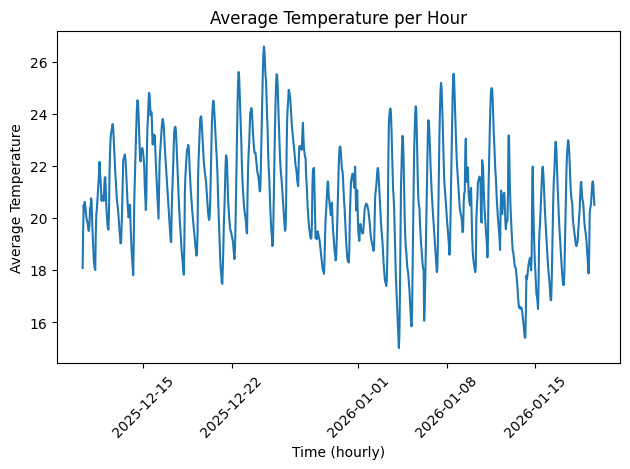

Graph saved to: avg_temperature_per_hour.png


,hour_bucket,avg_temperature,avg_humidity,avg_soil
0,2025-12-10 05:00:00+00:00,18.075000,54.750000,65.750000
1,2025-12-10 06:00:00+00:00,19.533333,53.500000,65.500000
2,2025-12-10 07:00:00+00:00,20.483333,51.000000,67.666667
3,2025-12-10 08:00:00+00:00,20.233333,52.333333,65.166667
4,2025-12-10 09:00:00+00:00,20.616667,52.333333,63.666667


In [ ]:
# Data Lake: df already contains raw sensor data loaded from the DB (Firebase/NoSQL)
df['timestamp'] = pd.to_datetime(df['timestamp'])  # Data Lake -> processing raw timestamps

# Map: create a time key for slicing (hourly buckets)
df['hour_bucket'] = df['timestamp'].dt.floor('H')  # Map phase (key = hour)

# Reduce: aggregate (average) per hour
agg_hourly = df.groupby('hour_bucket', as_index=False).agg(
    avg_temperature=('temperature', 'mean'),
    avg_humidity=('humidity', 'mean'),
    avg_soil=('soil', 'mean')
)  # Reduce phase (aggregation)

# Interactive Analytics: plot one "cut" of your choice (example: avg temperature over time)
plt.figure()
plt.plot(agg_hourly['hour_bucket'], agg_hourly['avg_temperature'])  # Interactive Analytics (graph)
plt.xlabel('Time (hourly)')
plt.ylabel('Average Temperature')
plt.title('Average Temperature per Hour')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the graph as an image for Word export
graph_path = "avg_temperature_per_hour.png"
plt.savefig(graph_path)  # Value: exporting insight for report
plt.show()

print("Graph saved to:", graph_path)
agg_hourly.head()

Report Generation and Visualization – Big Data Insights Export

In [ ]:
# Create Word document
doc = Document()
doc.add_heading('Big Data Sensor Analysis – Time-based Aggregation', level=1)

doc.add_paragraph(
    'The following graph presents an hourly aggregation of sensor data collected '
    'and stored in a NoSQL database acting as a Data Lake. '
    'The analysis was performed using a MapReduce-based approach, '
    'where data was grouped by time and aggregated to extract insights.'
)

# Add the graph
doc.add_picture('avg_temperature_per_hour.png', width=Inches(6))

# Save document
doc_path = 'sensor_data_analysis_report.docx'
doc.save(doc_path)

doc_path

'sensor_data_analysis_report.docx'

# ✅ GLOBAL CONFIG / THEME / CSS (OPTIONAL)

In [ ]:
# Global Configuration

# ============================================================================
# SERVER & FEED CONFIGURATION (YOUR ORIGINAL SETTINGS)
# ============================================================================
FEED = "json"  # Your feed name - CHANGE THIS if different
BASE_URL = "https://server-cloud-v645.onrender.com/"
BATCH_LIMIT = 200

# ============================================================================
# APP CONFIGURATION
# ============================================================================
APP_TITLE = "🌱 CloudGarden"
APP_SUBTITLE = "Smart Plant Disease Detection System"

# --- Colors for Friend's Realtime Dashboard ---
COLOR_TEMP = "#1f77b4"   # blue
COLOR_HUM  = "#ff7f0e"   # orange
COLOR_SOIL = "#2ca02c"   # green

STATUS_OK_COLOR = "#2ca02c"      # green
STATUS_WARN_COLOR = "#ffbf00"    # yellow
STATUS_BAD_COLOR = "#d62728"     # red

# --- ML Model Configuration ---
MODEL_NAME = "linkanjarad/mobilenet_v2_1.0_224-plant-disease-identification"
clf = pipeline("image-classification", model=MODEL_NAME)

# ============================================================================
# CSS STYLING FOR IOT DASHBOARD
# ============================================================================

COLORS = {
    'temperature': {'color': '#ef4444'},
    'humidity': {'color': '#3b82f6'},
    'soil': {'color': '#8b5cf6'}
}

CUSTOM_CSS = """
@import url('https://fonts.googleapis.com/css2?family=Inter:wght@400;500;600;700&display=swap');
* { font-family: 'Inter', sans-serif; }

.kpi-card {
    background: white;
    padding: 24px;
    border-radius: 12px;
    box-shadow: 0 1px 3px rgba(0,0,0,0.12);
    text-align: center;
    border-left: 4px solid;
}
.kpi-label { color: #6b7280; font-size: 14px; font-weight: 600; }
.kpi-value { font-size: 48px; font-weight: 700; color: #1f2937; }
.trend-up { color: #10b981; }
.trend-down { color: #ef4444; }

/* Tooltip styles */
.info-icon {
    position: relative;
    display: inline-flex;
    cursor: help;
}

.info-icon .tooltip-text {
    visibility: hidden;
    width: 200px;
    background-color: #1f2937;
    color: white;
    text-align: center;
    border-radius: 6px;
    padding: 8px;
    position: absolute;
    z-index: 1000;
    bottom: 125%;
    left: 50%;
    margin-left: -100px;
    opacity: 0;
    transition: opacity 0.3s;
    font-size: 11px;
    line-height: 1.4;
    box-shadow: 0 2px 8px rgba(0,0,0,0.2);
}

.info-icon .tooltip-text::after {
    content: "";
    position: absolute;
    top: 100%;
    left: 50%;
    margin-left: -5px;
    border-width: 5px;
    border-style: solid;
    border-color: #1f2937 transparent transparent transparent;
}

.info-icon:hover .tooltip-text {
    visibility: visible;
    opacity: 1;
}
"""

print('✅ Configuration loaded')
print(f'📡 Server: {BASE_URL}')
print(f'📻 Feed: {FEED}')
print(f'📦 Batch limit: {BATCH_LIMIT}')

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/9.34M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/408 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


model.safetensors:   0%|          | 0.00/9.26M [00:00<?, ?B/s]

✅ Configuration loaded
📡 Server: https://server-cloud-v645.onrender.com/
📻 Feed: json
📦 Batch limit: 200


# 🖥️ LAYER 5: Presentation Layer

# ✅ TAB REGISTRY (MODULAR)

  מוסיפים חלונית חדשה רק ע"י:
 1) הוספת TAB1 Logic - כל הפונקציות עזר למינהם.
 2) הוספת Tab1 GUI - כל GRADIO
 * יש להוריד את "with gr.Blocks() as demo:" ו "demo.launch()"

 3) להוסיף את שם הפונקציית GUI לרשימת הTAB למטה.

# ✅ TAB 1 Logic -  🌱 Realtime Dashboard


In [ ]:

# ---------- Core Data Fetch ----------
def load_iot_data(feed: str, limit: int) -> pd.DataFrame | None:
    resp = requests.get(
        f"{BASE_URL}/history",
        params={"feed": feed, "limit": limit},
        timeout=30
    )
    data = resp.json()
    if "data" not in data or not data["data"]:
        return None

    df = pd.DataFrame(data["data"])
    if "created_at" not in df.columns or "value" not in df.columns:
        return None

    df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce", utc=True)
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df = df.dropna(subset=["created_at", "value"]).sort_values("created_at")

    return None if df.empty else df


# ---------- Helpers ----------
def normalize(series: pd.Series) -> pd.Series:
    mn, mx = float(series.min()), float(series.max())
    if mx - mn == 0:
        return series * 0.0
    return (series - mn) / (mx - mn)


# ---------- Plant Status + Plots ----------
def plant_dashboard(limit: int):
    try:
        dfs = {
            "temperature": load_iot_data("temperature", limit),
            "humidity": load_iot_data("humidity", limit),
            "soil": load_iot_data("soil", limit),
        }

        missing = [k for k, v in dfs.items() if v is None]
        if missing:
            return "⚠️ Partial Data", f"Missing sensors or empty history: {', '.join(missing)}", None, None, None, None

        temp = float(dfs["temperature"]["value"].iloc[-1])
        hum = float(dfs["humidity"]["value"].iloc[-1])
        soil = float(dfs["soil"]["value"].iloc[-1])

        issues, warnings = [], []

        checks = [
            ("Temperature", temp, 18, 32, 1),
            ("Air humidity", hum, 35, 75, 3),
            ("Soil moisture", soil, 20, 60, 3),
        ]

        for name, value, low, high, margin in checks:
            if not (low <= value <= high):
                issues.append(f"{name} out of range ({value:.1f})")
            elif value <= low + margin or value >= high - margin:
                warnings.append(f"{name} near limit ({value:.1f})")

        if issues:
            status = "🔴 Plant Status: Not OK"
            details_main = " ; ".join(issues)

        elif warnings:
            status = "🟡 Plant Status: Warning"
            details_main = " ; ".join(warnings)

        else:
            status = "🟢 Plant Status: OK"
            details_main = "All sensors are within valid ranges"

        details = (
    f"{details_main}\n"
    f"Latest values:\n"
    f"temp={temp:.1f}\n"
    f"humidity={hum:.1f}\n"
    f"soil={soil:.1f}"

        )

        df_t, df_h, df_s = dfs["temperature"], dfs["humidity"], dfs["soil"]

        fig_t = plt.figure(figsize=(7, 3.2))
        plt.plot(df_t["created_at"], df_t["value"], marker="o", color=COLOR_TEMP)
        plt.title("Temperature History")
        plt.xlabel("Time")
        plt.ylabel("°C")
        plt.grid(True)

        fig_h = plt.figure(figsize=(7, 3.2))
        plt.plot(df_h["created_at"], df_h["value"], marker="o", color=COLOR_HUM)
        plt.title("Air Humidity History")
        plt.xlabel("Time")
        plt.ylabel("%")
        plt.grid(True)

        fig_s = plt.figure(figsize=(7, 3.2))
        plt.plot(df_s["created_at"], df_s["value"], marker="o", color=COLOR_SOIL)
        plt.title("Soil Moisture History")
        plt.xlabel("Time")
        plt.ylabel("%")
        plt.grid(True)

        fig_c = plt.figure(figsize=(10, 3.4))
        plt.plot(df_t["created_at"], normalize(df_t["value"]), marker="o", label="Temperature (norm)", color=COLOR_TEMP)
        plt.plot(df_h["created_at"], normalize(df_h["value"]), marker="o", label="Humidity (norm)", color=COLOR_HUM)
        plt.plot(df_s["created_at"], normalize(df_s["value"]), marker="o", label="Soil (norm)", color=COLOR_SOIL)
        plt.title("Combined Trend (Normalized)")
        plt.xlabel("Time")
        plt.ylabel("Normalized Value (0–1)")
        plt.grid(True)
        plt.legend()

        return status, details, fig_t, fig_h, fig_s, fig_c

    except Exception:
        return "❌ Error", "Failed to fetch data from server. Please try again.", None, None, None, None


# ✅ Tab 1 GUI - - 🌱 Realtime Dashboard


In [ ]:
def build_realtime_dashboard_tab():
    gr.Markdown(
    "<h3 style='margin:0; font-size:22px;'>🌿 Overall Plant Status (Real-Time)</h3>"
)


    samples = gr.Slider(1, 200, value=20, step=1, label="Number of Samples (used for all graphs)")
    overall_btn = gr.Button("Update Plant Dashboard", variant="primary")



    overall_status = gr.Textbox(
        label="Overall Status",
        lines=1,
        placeholder="Click 'Update Plant Dashboard' to evaluate plant status"
    )
    overall_info = gr.Textbox(
        label="Status Details",
        lines=4,
        placeholder="Detailed plant analysis will appear here"
    )

    with gr.Row():
        gr.Markdown(f"""
<div class="legend-card" style="margin-top:14px;padding:14px;border:1px solid var(--border-color-primary)
;border-radius:10px;">




  <h4 style="margin-bottom:10px; font-size:20px; font-weight:600;">
🌿 Plant Status
</h4>


  <span style="color:{STATUS_OK_COLOR};font-size:26px;">●</span>
  <b>Healthy</b> – All sensor values within normal ranges<br>

  <span style="color:{STATUS_WARN_COLOR};font-size:26px;">●</span>
  <b>Warning</b> – At least one value near threshold<br>

  <span style="color:{STATUS_BAD_COLOR};font-size:26px;">●</span>
  <b>Not OK</b> – One or more values out of range<br><br>

  <span>Status is calculated automatically from sensor data</span>
</div>
        """)

        gr.Markdown(f"""
<div class="legend-card" style="margin-top:14px;padding:14px;border:1px solid var(--border-color-primary)
;border-radius:10px;">




  <h4 style="margin-bottom:10px; font-size:20px; font-weight:600;">
ℹ️ Valid Value Ranges
</h4>


  <span style="color:{COLOR_TEMP};font-size:26px;">●</span>
  🌡️ <b>Temperature</b>: 18–32°C<br>

  <span style="color:{COLOR_HUM};font-size:26px;">●</span>
  💧 <b>Air Humidity</b>: 35–75%<br>

  <span style="color:{COLOR_SOIL};font-size:26px;">●</span>
  🌱 <b>Soil Moisture</b>: 20–60%<br><br>

  <span>⚠️ Values outside these ranges are considered abnormal</span>
</div>
        """)

    gr.Markdown("""
<h2 style="text-align:center; margin-top:22px; font-size:26px; font-weight:600;">
📈 Plant Sensor Graphs
</h2>
""")

    with gr.Row():
        plot_temp = gr.Plot(label="Temperature")
        plot_hum = gr.Plot(label="Air Humidity")

    with gr.Row():
        plot_soil = gr.Plot(label="Soil Moisture")
        plot_combined = gr.Plot(label="Combined (Normalized)")

    overall_btn.click(
        fn=plant_dashboard,
        inputs=[samples],
        outputs=[overall_status, overall_info, plot_temp, plot_hum, plot_soil, plot_combined]
    )

# ✅ TAB 2 LOGIC - 📄 Generate Report

In [ ]:
# =========================================================
# TAB 3 — Generate Report (LOGIC ONLY) | CLIENT (NO AI HERE)
# =========================================================

REPORT_SERVICE_URL = "http://127.0.0.1:8001/generate-docx"

def df_to_records(df):
    """
    Convert DataFrame with columns [created_at, value] into JSON-friendly list.
    """
    if df is None or df.empty:
        return []
    out = df[["created_at", "value"]].copy()
    out["created_at"] = out["created_at"].astype(str)
    return out.to_dict("records")

def call_report_microservice(dfs: dict, limit: int) -> str:
    """
    Send sensor data to microservice and save returned DOCX to temp file.
    Returns local path for Gradio download.
    """
    payload = {
        "limit": int(limit),
        "temperature": df_to_records(dfs.get("temperature")),
        "humidity": df_to_records(dfs.get("humidity")),
        "soil": df_to_records(dfs.get("soil")),
    }

    r = requests.post(REPORT_SERVICE_URL, json=payload, timeout=120)
    if not r.ok:
        raise RuntimeError(f"Microservice error: {r.status_code} | {r.text}")

    fd, path = tempfile.mkstemp(suffix=".docx", prefix="daily_report_")
    os.close(fd)
    with open(path, "wb") as f:
        f.write(r.content)

    return path

def generate_report_screen(limit: int):
    """
    Gradio button handler (same signature as before).
    Returns: (status_text, file_path_or_None)
    """
    try:
        dfs = {
            "temperature": load_iot_data("temperature", limit),
            "humidity": load_iot_data("humidity", limit),
            "soil": load_iot_data("soil", limit),
        }

        if all(df is None or df.empty for df in dfs.values()):
            return "No data available to generate a report.", None

        out_path = call_report_microservice(dfs, limit)
        return "✅ Report generated successfully. Download below:", out_path

    except Exception as e:
        return f"❌ Error generating report: {str(e)}", None

# ✅ TAB 2 GUI - 📄 Generate Report

In [ ]:
# =========================================================
# TAB 2 — Generate Report (GUI ONLY)
# =========================================================

def build_generate_report_tab():
    gr.Markdown("## 📄 Generate Report")
    gr.Markdown("Generate a Word (DOCX) report based on sensor data: temperature, humidity, and soil moisture. (English AI summary)")

    report_samples = gr.Slider(
        minimum=5,
        maximum=200,
        value=20,
        step=1,
        label="Number of samples per sensor"
    )

    report_btn = gr.Button("📥 Generate & Download Report", variant="primary")
    report_status = gr.Textbox(label="Status", lines=2)
    report_file = gr.File(label="Download DOCX")

    report_btn.click(
        fn=generate_report_screen_gamified,   # מגיע מה-LOGIC tab
        inputs=[report_samples],
        outputs=[report_status, report_file]
    )


# ✅ TAB 3 LOGIC - 🖼️ Plant Disease Detection

In [ ]:
def analyze_plant(image, temp, humidity, soil):
    preds = clf(image)
    top = preds[0]

    label = top["label"]
    score = top["score"]

    alerts = []
    advice = []

    # --- Conditions based on sensors / user input ---
    # Temperature: 18–32°C
    if temp < 18:
      alerts.append("Low temperature")
      advice.append("Recommendation: move plant to a warmer environment")

    elif temp > 32:
      alerts.append("High temperature")
      advice.append("Recommendation: move the plant to a shaded area")

    # Air Humidity: 35–75%
    if humidity < 35:
      alerts.append("Low air humidity")
      advice.append("Recommendation: increase humidity (e.g. misting)")

    elif humidity > 75:
      alerts.append("High air humidity")
      advice.append("Recommendation: improve ventilation")

    # Soil Moisture: 20–60%
    if soil < 20:
      alerts.append("Low soil moisture")
      advice.append("Recommendation: irrigate / water the plant")

    elif soil > 60:
      alerts.append("High soil moisture")
      advice.append("Recommendation: reduce watering")


    # --- Color status ("flag") based on image prediction ---
    # Simple rule: if label contains "healthy" => good (green), else bad (red)
    is_bad = ("healthy" not in label.lower())

    status_html = (
        "<div style='padding:10px;border-radius:10px;"
        f"background:{'#ffdddd' if is_bad else '#ddffdd'};"
        f"border:1px solid {'#ff0000' if is_bad else '#00aa00'};"
        "font-weight:700;'>"
        f"{'🔴 Plant status: BAD' if is_bad else '🟢 Plant status: GOOD'}"
        "</div>"
    )

    if not alerts:
        alerts.append("Status looks normal")

    return (
        f"Detected disease: {label} ({score:.2%})",
        status_html,
        "\n".join(alerts),
        "\n".join(advice)
    )

# ✅ TAB 3 GUI - 🖼️ Plant Disease Detection

In [ ]:
def build_plant_disease_detection_tab():
    gr.Markdown("## 🖼️ Plant Disease Detection")

    with gr.Row():

        # -------- LEFT SIDE --------
        with gr.Column(scale=2):

            image = gr.Image(
                type="filepath",
                label="Upload plant image",
                sources=["upload"]
            )

            temp = gr.Slider(0, 45, value=25, label="Temperature (°C)")
            humidity = gr.Slider(0, 100, value=50, label="Humidity (%)")
            soil = gr.Slider(0, 100, value=50, label="Soil Moisture (%)")

            run_btn = gr.Button("Analyze Plant", variant="primary")

        # -------- RIGHT SIDE --------
        with gr.Column(scale=2):

            diagnosis = gr.Textbox(
                label="Diagnosis",
                placeholder="Plant disease diagnosis will appear here"
            )

            status = gr.HTML(label="Status")

            alerts = gr.Textbox(
                label="Alerts",
                lines=5,
                placeholder="Sensor alerts and warnings will appear here"
            )

            recommendations = gr.Textbox(
                label="Recommendations",
                lines=5,
                placeholder="Care and treatment recommendations will appear here"
            )

    run_btn.click(
        fn=analyze_plant_gamified,
        inputs=[image, temp, humidity, soil],
        outputs=[diagnosis, status, alerts, recommendations]
    )

# ✅ TAB 4 LOGIC - RAG Chat

In [ ]:
DOC_URLS = [
    "https://doi.org/10.1038/s41598-025-20629-y",
    "https://doi.org/10.3389/fpls.2016.01419",
    "https://doi.org/10.1038/s41598-025-05102-0",
    "https://doi.org/10.1038/s41598-025-04758-y",
    "https://doi.org/10.2174/0118743315321139240627092707",
]

In [ ]:
# =========================
# Cell 2: HTTP / Session setup
# =========================
# Purpose: Shared HTTP session + helper functions to fetch HTML/PDF and query academic APIs (Semantic Scholar/OpenAlex/Unpaywall).



# Reuse a single session for performance and consistent headers/cookies.
session = requests.Session()

# Browser-like headers to improve compatibility with some sites.
BROWSER_HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9",
}

# Normalize DOI input (accept DOI or doi.org URL).
def _normalize_doi(doi_or_url: str) -> str:
    s = (doi_or_url or "").strip()
    s = s.replace("https://doi.org/", "").replace("http://doi.org/", "")
    return s.strip()

# ---------- Added: text quality post-processing helpers ----------

_STOP_SECTION_TITLES = {
    "references", "reference", "bibliography",
    "acknowledgements", "acknowledgments",
    "author information", "ethics declarations",
    "additional information", "supplementary information",
    "rights and permissions", "about this article",
    "availability of data and materials", "data availability",
    "publisher's note"
}

_SKIP_LINE_RES = [
    re.compile(r"(?i)^\s*cite this article\s*$"),
    re.compile(r"(?i)^\s*article\s+google\s+scholar\s*$"),
    re.compile(r"(?i)^\s*google\s+scholar\s*$"),
    re.compile(r"(?i)^\s*pubmed\s*$"),
    re.compile(r"(?i)^\s*pubmed\s+central\s*$"),
    re.compile(r"(?i)^\s*ads\s*$"),
    re.compile(r"(?i)^\s*cas\s*$"),
    re.compile(r"(?i)creative\s+commons"),
    re.compile(r"(?i)springer\s+nature"),
    re.compile(r"(?i)sharedit"),
    re.compile(r"(?i)correspondence\s+to"),
    re.compile(r"(?i)the\s+authors\s+declare\s+no\s+competing\s+interests"),
    re.compile(r"(?i)view\s+author\s+publications"),
    re.compile(r"(?i)search\s+author\s+on"),
    re.compile(r"(?i)anyone\s+you\s+share\s+the\s+following\s+link"),
    re.compile(r"(?i)version\s+of\s+record"),
    re.compile(r"(?i)copyright"),
    re.compile(r"(?i)rights\s+reserved"),
]

def normalize_text_keep_newlines(text: str) -> str:
    """Normalize whitespace while preserving newlines."""
    if not text:
        return ""
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    # Collapse spaces/tabs inside lines
    text = "\n".join(re.sub(r"[ \t]+", " ", ln).strip() for ln in text.split("\n"))
    # Collapse too many blank lines
    text = re.sub(r"\n{3,}", "\n\n", text).strip()
    return text

def looks_like_blocked_or_boilerplate(text: str) -> bool:
    """Detect common anti-bot/paywall/cookie boilerplate that inflates text."""
    s = (text or "").strip().lower()
    if not s:
        return False
    bad_phrases = [
        "verify you are human",
        "enable javascript",
        "turn on javascript",
        "access denied",
        "unusual traffic",
        "cookie",
        "cookies",
        "privacy policy",
        "terms of use",
        "we value your privacy",
        "sign in to continue",
        "subscribe to",
        "accept all cookies",
        "manage cookies",
    ]
    return any(p in s for p in bad_phrases)

def _should_skip_line(line: str) -> bool:
    s = (line or "").strip()
    if not s:
        return False
    if len(s) <= 3:
        return True
    for rx in _SKIP_LINE_RES:
        if rx.search(s):
            return True
    return False

def postprocess_document_text(text: str, max_chars: int = 50000) -> str:
    """
    Normalize + remove boilerplate + cut references + de-duplicate paragraphs.
    Keeps 'TITLE:' / 'ABSTRACT:' markers if present.
    """
    text = normalize_text_keep_newlines(text or "")
    if not text:
        return ""

    # Remove noisy single lines
    lines = []
    for ln in text.splitlines():
        if _should_skip_line(ln):
            continue
        if looks_like_blocked_or_boilerplate(ln):
            continue
        lines.append(ln.rstrip())
    text = "\n".join(lines).strip()
    if not text:
        return ""

    # Cut everything after an explicit references/bibliography header line
    m = re.search(r"(?im)^\s*(references|bibliography)\s*$", text)
    if m:
        text = text[:m.start()].rstrip()

    # Keep only the first TITLE: line if repeated
    out_lines = []
    title_seen = False
    for ln in text.splitlines():
        if ln.startswith("TITLE:"):
            if title_seen:
                continue
            title_seen = True
        out_lines.append(ln)
    text = "\n".join(out_lines).strip()

    # Paragraph de-duplication (removes duplicates anywhere, not only consecutive)
    paras = [p.strip() for p in re.split(r"\n{2,}", text) if p.strip()]
    seen = set()
    deduped = []
    for p in paras:
        key = re.sub(r"\W+", "", p.lower())[:900]
        if key in seen:
            continue
        seen.add(key)
        deduped.append(p)

    text = "\n\n".join(deduped).strip()

    # Hard cap (avoid storing extremely large junk)
    if len(text) > max_chars:
        text = text[:max_chars].rstrip()

    return text

# Fetch HTML and return (html_text, final_url, status_code).
def fetch_html(url: str, timeout: int = 25):
    r = session.get(
        url,
        headers={**BROWSER_HEADERS, "Accept": "text/html,*/*;q=0.8"},
        timeout=timeout,
        allow_redirects=True
    )
    return (r.text or ""), r.url, r.status_code

# Extract readable main text from HTML (title/description/body).
def extract_main_text_from_html(html: str) -> str:
    try:
        from bs4 import BeautifulSoup
    except ImportError:
        raise ImportError("Install bs4 + lxml: pip install beautifulsoup4 lxml")

    soup = BeautifulSoup(html, "lxml")

    # Remove obvious non-content areas
    for tag in soup(["script", "style", "noscript", "svg", "iframe"]):
        tag.decompose()
    for tag in soup.find_all(["header", "footer", "nav", "aside", "form"]):
        tag.decompose()

    root = soup.find("main") or soup.find("article") or soup

    title = soup.title.string.strip() if soup.title and soup.title.string else ""
    desc = ""
    m = soup.find("meta", attrs={"name": "description"})
    if m and m.get("content"):
        desc = m["content"].strip()

    chunks = []
    for el in root.find_all(["h1", "h2", "h3", "p", "li"]):
        t = el.get_text(" ", strip=True)

        # Stop when reaching tail sections (References, etc.)
        if el.name in ["h1", "h2", "h3"]:
            if (t or "").strip().lower() in _STOP_SECTION_TITLES:
                break

        if not t or len(t) < 30:
            continue
        if looks_like_blocked_or_boilerplate(t):
            continue
        if _should_skip_line(t):
            continue

        chunks.append(t)

    # Fallback if structure is weak
    if len(chunks) < 3:
        t = re.sub(r"\s+", " ", root.get_text(" ", strip=True)).strip()
        chunks = [t] if t else []

    # De-duplicate keeping order
    chunks = list(dict.fromkeys(chunks))

    # IMPORTANT: keep paragraph boundaries so paragraph de-dup works later
    body = "\n\n".join(chunks).strip()

    # Drop DESCRIPTION if it's basically contained in the body
    if desc:
        norm_desc = re.sub(r"\W+", "", desc.lower())
        norm_body_head = re.sub(r"\W+", "", body.lower()[: max(2000, len(desc) * 3)])
        if norm_desc and norm_desc in norm_body_head:
            desc = ""

    parts = []
    if title:
        parts.append(f"TITLE: {title}")
    if desc:
        parts.append(f"DESCRIPTION: {desc}")
    if body:
        parts.append(body)

    return postprocess_document_text("\n\n".join(parts).strip())


# API lookup: Semantic Scholar (metadata + possible openAccessPdf).
def semantic_scholar_lookup(doi: str):
    """Return dict with title/abstract and possibly openAccessPdf url."""
    # No key required for basic use, but rate-limited.
    url = f"https://api.semanticscholar.org/graph/v1/paper/DOI:{quote(doi, safe='')}"
    params = {"fields": "title,abstract,openAccessPdf,url"}
    r = session.get(url, params=params, headers=BROWSER_HEADERS, timeout=25)
    if r.status_code != 200:
        return None
    return r.json()

# API lookup: OpenAlex (metadata + locations + inverted-index abstract).
def openalex_lookup(doi: str):
    url = f"https://api.openalex.org/works/doi:{quote(doi, safe='')}"
    r = session.get(url, headers=BROWSER_HEADERS, timeout=25)
    if r.status_code != 200:
        return None
    return r.json()

# API lookup: Unpaywall (OA locations; requires email parameter).
def unpaywall_lookup(doi: str, email: str = "test@example.com"):
    # Unpaywall requires an email parameter (your real email is best).
    url = f"https://api.unpaywall.org/v2/{quote(doi, safe='')}"
    r = session.get(url, params={"email": email}, headers=BROWSER_HEADERS, timeout=25)
    if r.status_code != 200:
        return None
    return r.json()

# Select the best PDF URL from available sources (Semantic Scholar/OpenAlex/Unpaywall).
def _pick_pdf_url_from_sources(ss=None, oa=None, up=None) -> str:
    # 1) Semantic Scholar openAccessPdf
    if ss and isinstance(ss, dict):
        oap = ss.get("openAccessPdf") or {}
        if isinstance(oap, dict) and oap.get("url"):
            return oap["url"]

    # 2) OpenAlex primary_location / open_access
    if oa and isinstance(oa, dict):
        pl = oa.get("primary_location") or {}
        if isinstance(pl, dict):
            pdf = pl.get("pdf_url")
            if pdf:
                return pdf
            landing = pl.get("landing_page_url")
            if landing and landing.lower().endswith(".pdf"):
                return landing
        oa2 = oa.get("open_access") or {}
        if isinstance(oa2, dict):
            oa_url = oa2.get("oa_url")
            if oa_url and oa_url.lower().endswith(".pdf"):
                return oa_url

    # 3) Unpaywall best_oa_location
    if up and isinstance(up, dict):
        bol = up.get("best_oa_location") or {}
        if isinstance(bol, dict):
            pdf = bol.get("url_for_pdf")
            if pdf:
                return pdf
            url = bol.get("url")
            if url and url.lower().endswith(".pdf"):
                return url

    return ""

# Download a PDF and extract text from the first pages (bounded by max_pages).
def extract_text_from_pdf_url(pdf_url: str, max_pages: int = 8) -> str:
    """Download PDF and extract text from first max_pages pages."""
    r = session.get(
        pdf_url,
        headers={**BROWSER_HEADERS, "Accept": "application/pdf,*/*;q=0.8"},
        timeout=40,
        allow_redirects=True
    )
    if r.status_code != 200 or not r.content:
        return ""

    data = r.content

    # pypdf
    try:
        from pypdf import PdfReader
        import io
        reader = PdfReader(io.BytesIO(data))
        out = []
        n = min(len(reader.pages), max_pages)
        for i in range(n):
            out.append(reader.pages[i].extract_text() or "")
        text = "\n".join(out).strip()
        text = re.sub(r"\s+", " ", text)
        return text.strip()
    except Exception:
        pass

    # pdfminer
    try:
        from pdfminer.high_level import extract_text
        import io
        text = extract_text(io.BytesIO(data), maxpages=max_pages) or ""
        text = re.sub(r"\s+", " ", text).strip()
        return text
    except Exception:
        return ""

# Utility: reconstruct OpenAlex inverted-index abstract into ordered text.
def _reconstruct_abstract_from_inverted_index(inv: dict) -> str:
    """
    OpenAlex returns abstracts as an inverted index:
    {word: [pos1, pos2, ...], ...}
    This reconstructs the abstract text in the correct order.
    """
    if not isinstance(inv, dict) or not inv:
        return ""

    # Find max position to size the token list
    max_pos = -1
    for positions in inv.values():
        if isinstance(positions, list) and positions:
            mp = max(positions)
            if mp > max_pos:
                max_pos = mp

    if max_pos < 0:
        return ""

    tokens = [""] * (max_pos + 1)

    for word, positions in inv.items():
        if not isinstance(positions, list):
            continue
        for p in positions:
            if isinstance(p, int) and 0 <= p < len(tokens):
                tokens[p] = word

    # Join; remove empties
    text = " ".join(t for t in tokens if t)
    return text.strip()


In [ ]:
# =========================
# 3. DOI Metadata fallback (only if HTML is short)
# =========================
# Purpose: Fetch usable document text from a URL with fallbacks:
# HTML -> Open-Access PDF (via APIs) -> Abstract metadata -> Title-only.

def get_document_text(url: str, min_chars: int = 800, unpaywall_email: str = "test@example.com", debug: bool = False) -> str:
    """
    Returns the best available text we can legally obtain.
    Order:
      1) HTML extraction (if enough)
      2) OA PDF extraction via Semantic Scholar / OpenAlex / Unpaywall (if available)
      3) Abstract via Semantic Scholar/OpenAlex (fallback)
      4) Title only
    """

    # 1) Try extracting text directly from the landing HTML page.
    html, final_url, status = fetch_html(url)
    text_html_raw = extract_main_text_from_html(html) if html else ""
    text_html = postprocess_document_text(text_html_raw)

    # Optional debug printing for tracing which path is used.
    if debug:
        print("final_url:", final_url)
        print("html_status:", status, "| html_text_chars_raw:", len(text_html_raw), "| html_text_chars_clean:", len(text_html))

    # If cleaned HTML content is sufficient, return it immediately.
    if len(text_html) >= min_chars:
        return text_html

    # 2) If input is a DOI link or a DOI string, try Open-Access routes (PDF).
    u = (url or "").strip()
    doi = ""
    if "doi.org/" in u:
        doi = _normalize_doi(u)
    elif re.match(r"^10\.\d{4,9}/\S+$", u):
        doi = _normalize_doi(u)

    ss = oa = up = None

    if doi:
        # Query multiple services to maximize chances of finding an OA PDF.
        try:
            ss = semantic_scholar_lookup(doi)
        except Exception:
            ss = None
        try:
            oa = openalex_lookup(doi)
        except Exception:
            oa = None
        try:
            up = unpaywall_lookup(doi, email=unpaywall_email)
        except Exception:
            up = None

        # Pick the best PDF URL from the available sources (if any).
        pdf_url = _pick_pdf_url_from_sources(ss=ss, oa=oa, up=up)
        if debug:
            print("pdf_url:", pdf_url or "(none)")

        # If we found a PDF, extract text from the first pages.
        if pdf_url:
            pdf_text_raw = extract_text_from_pdf_url(pdf_url, max_pages=8)
            # Optionally prepend a title header when available.
            title = (ss or {}).get("title") or (oa or {}).get("title") or ""
            title = title.get("display_name") if isinstance(title, dict) else title
            header = f"TITLE: {title}".strip() if title else ""

            merged = (header + "\n" + pdf_text_raw).strip() if header else (pdf_text_raw or "").strip()
            pdf_text = postprocess_document_text(merged)

            if debug:
                print("pdf_text_chars_raw:", len(pdf_text_raw), "| pdf_text_chars_clean:", len(pdf_text))

            if len(pdf_text) >= min_chars:
                return pdf_text

        # 3) If PDF is missing/short, fall back to abstract metadata (when present).
        title = ""
        abstract = ""

        if ss and isinstance(ss, dict):
            title = (ss.get("title") or "").strip()
            abstract = (ss.get("abstract") or "").strip()

        if (not abstract) and oa and isinstance(oa, dict):
            t = oa.get("title") or ""
            title = title or t
            # OpenAlex abstract can be stored as an inverted index.
            inv = oa.get("abstract_inverted_index")
            if inv:
                abstract = _reconstruct_abstract_from_inverted_index(inv)

        # Return any metadata we managed to obtain.
        if title or abstract:
            parts = []
            if title:
                parts.append(f"TITLE: {title}")
            if abstract:
                parts.append(f"ABSTRACT: {abstract}")
            return postprocess_document_text("\n".join(parts).strip())

    # 4) Last resort: return thin HTML (title/description) if present.
    if text_html:
        return postprocess_document_text(text_html.strip())

    # Final fallback: return the URL as a minimal title marker.
    return postprocess_document_text(f"TITLE: {url}".strip())


In [ ]:
# =========================
# 4. NLP Preprocessing
# =========================
# Purpose: Standardize text into comparable tokens for indexing/search.
# Pipeline: tokenize -> stopword removal -> stemming.

def tokenize(text):
    """Convert text to a list of lowercase word tokens."""
    return re.findall(r"\w+", (text or "").lower())

def remove_stopwords(tokens, stop_words):
    """Remove stop words from a list of tokens."""
    return [t for t in tokens if t not in stop_words]

def apply_stemming(tokens):
    """Apply Porter stemming to a list of tokens."""
    return [stemmer.stem(t) for t in tokens]


def preprocess_query(query: str):
    # Goal: Apply the same normalization steps used for documents to the user query.
    tokens = tokenize(query)
    tokens = remove_stopwords(tokens, stop_words)
    tokens = apply_stemming(tokens)
    return tokens


In [ ]:
# =========================
# 5. Document Text Access
# =========================
# Purpose: Fetch and store raw text for each document URL so it can be indexed later.
# Output: doc_text dict mapping doc_id -> extracted text (may be empty on failure).

def build_doc_text_map(doc_urls, min_chars=800, unpaywall_email="test@example.com", debug=False):
    doc_text = {}
    for i, url in enumerate(doc_urls):
        # Try to extract the best available text (HTML/PDF/abstract fallback).
        try:
            doc_text[i] = get_document_text(
                url,
                min_chars=min_chars,
                unpaywall_email=unpaywall_email,
                debug=debug
            ) or ""
        except Exception as e:
            # Keep the pipeline running even if a document fails to fetch.
            print(f"Failed to fetch document {i}: {e}")
            doc_text[i] = ""
    return doc_text


# Placeholder / initialization for the document-text mapping (doc_id -> text).
doc_text = {}


In [ ]:
# =========================
# 6. Index Construction
# =========================
# Purpose: Build an inverted index for fast keyword-based retrieval.
# - Input: raw document texts (doc_text) and preprocessing settings (stop_words).
# - Output:
#   1) inverted: term -> list of doc_ids containing the term
#   2) doc_map: doc_id -> original URL

def build_inverted_index(urls, stop_words, doc_text):
    inverted = defaultdict(set)  # term -> set(doc_ids)
    doc_map = {i: url for i, url in enumerate(urls)}  # DocID -> URL

    for doc_id in range(len(urls)):
        # Get the stored text for this document (support int or string keys).
        text = doc_text.get(doc_id) or doc_text.get(str(doc_id)) or ""

        # Normalize document text into searchable terms.
        tokens = tokenize(text)
        tokens = remove_stopwords(tokens, stop_words)
        tokens = apply_stemming(tokens)

        # Add each unique term to the index for this document.
        for term in set(tokens):
            inverted[term].add(doc_id)

    # Convert sets to sorted lists for stable output/serialization.
    inverted = {term: sorted(list(ids)) for term, ids in inverted.items()}
    return inverted, doc_map


In [ ]:
# =========================
# 7. Firebase I/O
# =========================
# Purpose: Persist and reuse the document store in Firebase.
# Stored objects:
# - doc_text: doc_id -> extracted text
# - public_index: inverted index (term -> doc_ids)
# - doc_map: doc_id -> source URL

def save_to_firebase(data, path):
    # Write JSON data to a Firebase Realtime Database path using HTTP PUT.
    base = FIREBASE_URL.rstrip("/")
    url = f"{base}/{path}.json"
    r = requests.put(url, json=data, timeout=30)
    print("PUT", path, "status:", r.status_code, "| resp:", r.text[:200])
    if r.status_code != 200:
        raise RuntimeError(f"PUT {path} failed: {r.status_code} | {r.text[:400]}")
    return r.status_code, r.text


def firebase_get(path):
    # Read JSON data from a Firebase Realtime Database path using HTTP GET.
    base = FIREBASE_URL.rstrip("/")
    url = f"{base}/{path}.json"
    r = requests.get(url, timeout=30)
    print("GET", path, "status:", r.status_code, "| resp:", r.text[:200])
    if r.status_code != 200:
        raise RuntimeError(f"GET {path} failed: {r.status_code} | {r.text[:400]}")
    return r.json()


def build_and_save_index(
    urls,
    stop_words,
    index_path="indexes/public_index",
    map_path="indexes/doc_map",
    text_path="indexes/doc_text"):
    # Orchestrator: build doc_text + inverted index locally, then save all artifacts to Firebase.

    # 1) Build doc_text locally
    doc_text_local = build_doc_text_map(urls)

    # Save doc_text with string keys (JSON consistency)
    doc_text_to_save = {str(k): v for k, v in doc_text_local.items()}
    save_to_firebase(doc_text_to_save, text_path)
    print("✅ doc_text saved")

    # 2) Build index + doc_map using doc_text_local
    inv_index, doc_map = build_inverted_index(urls, stop_words, doc_text_local)

    # Save doc_map with string keys
    doc_map_json = {str(k): v for k, v in doc_map.items()}
    save_to_firebase(inv_index, index_path)
    print("✅ index saved")

    save_to_firebase(doc_map_json, map_path)
    print("✅ doc_map saved")

    return inv_index, doc_map_json, doc_text_local

# Load existing store from Firebase if present; otherwise build once and save.
existing_index = firebase_get("indexes/public_index")  # None if missing
existing_map   = firebase_get("indexes/doc_map")
existing_text  = firebase_get("indexes/doc_text")

if existing_index is not None and existing_map is not None and existing_text is not None:
    # Reuse cached data to avoid rebuilding/re-fetching documents.
    inv_index = existing_index
    doc_map_json = existing_map
    doc_text_local = existing_text
    print("✅ Loaded existing store from Firebase (no rebuild).")
else:
    # First-time setup: build and persist the store.
    inv_index, doc_map_json, doc_text_local = build_and_save_index(DOC_URLS, stop_words)
    print("✅ Built and saved store to Firebase.")

# Expose globals used by retrieval/search code.
public_index = inv_index
doc_map = doc_map_json


GET indexes/public_index status: 200 | resp: {"000":[0,4],"0001":[2,3,4],"002":[1],"003":[1],"004":[1],"006":[4],"007":[1],"008":[1,4],"009":[1],"014":[1],"015":[1],"025":[0,2,3],"100":[0,1,3],"101":[4],"103":[2],"104":[3],"106":[1],"110":[1],"1
GET indexes/doc_map status: 200 | resp: ["https://doi.org/10.1038/s41598-025-20629-y","https://doi.org/10.3389/fpls.2016.01419","https://doi.org/10.1038/s41598-025-05102-0","https://doi.org/10.1038/s41598-025-04758-y","https://doi.org/10.21
GET indexes/doc_text status: 200 | resp: ["TITLE: Medicinal plant leaf disease classification using optimal weighted features with dilated adaptive DenseNet and attention mechanism | Scientific Reports\nDESCRIPTION: The agriculture sector pl
✅ Loaded existing store from Firebase (no rebuild).


In [ ]:
# =========================
# 8 Load store from Firebase
# =========================
# Purpose: Load previously saved index artifacts from Firebase into runtime globals.
# Loads: public_index (inverted index), doc_map (doc_id -> URL), and optionally doc_text.

INDEX_PATH = "indexes/public_index"
MAP_PATH   = "indexes/doc_map"
TEXT_PATH  = "indexes/doc_text"

public_index = None
doc_map = None
doc_text = None

def load_store_from_firebase(load_text: bool = False):
    # Load index + doc_map from Firebase into globals
    global public_index, doc_map, doc_text

    # Always load index and doc_map (use empty dict if missing).
    public_index = firebase_get(INDEX_PATH) or {}
    doc_map = firebase_get(MAP_PATH) or {}

    # Normalize doc_map shape if Firebase returns a JSON array instead of an object.
    if isinstance(doc_map, list):
      doc_map = {str(i): v for i, v in enumerate(doc_map)}

    # Optionally load the full document texts (can be large).
    if load_text:
        doc_text = firebase_get(TEXT_PATH) or {}

    # Basic summary for quick sanity-check.
    print("Loaded:",
          "terms=", len(public_index),
          "| docs=", len(doc_map) if hasattr(doc_map, "__len__") else type(doc_map))

    return public_index, doc_map, doc_text


In [ ]:
# =========================
# 9. Retrieval (uses data loaded from Firebase)
# =========================
# Purpose: Perform simple keyword-based retrieval using the inverted index.
# Method: preprocess query -> count matching terms per document -> return top-k docs.

def search_top_k(query: str, k: int = 3):
    # Ensure index and doc_map are available in memory (load if missing).
    if public_index is None or doc_map is None:
        load_store_from_firebase(load_text=False)

    # Convert the raw query into normalized terms (tokenize/stopwords/stemming).
    q_terms = preprocess_query(query)
    scores = defaultdict(int)

    # Score documents by how many query terms they contain.
    for term in q_terms:
        for doc_id in (public_index.get(term, []) or []):
            scores[int(doc_id)] += 1

    # Rank by score and keep the top-k.
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:k]

    # Build a compact result list with doc id, score, and source URL.
    results = []
    for doc_id, score in ranked:
        url = doc_map.get(str(doc_id)) if isinstance(doc_map, dict) else None
        results.append({"doc_id": doc_id, "score": score, "url": url})

    return q_terms, results


In [ ]:
# English comments only
drive_link = "https://drive.google.com/file/d/1vuCquKjZPwCHVNbRoLfAay7MxI7MjOru/view?usp=sharing"
m = re.search(r"/d/([a-zA-Z0-9_-]+)", drive_link) or re.search(r"id=([a-zA-Z0-9_-]+)", drive_link)
if not m:
    raise RuntimeError("Could not extract file id from the link")

file_id = m.group(1)
download_url = f"https://drive.google.com/uc?id={file_id}"

out_path = "/content/my_text.txt"
gdown.download(download_url, out_path, quiet=False)

with open(out_path, "r", encoding="utf-8") as f:
    drive_key_1 = f.read().strip()

Downloading...
From: https://drive.google.com/uc?id=1vuCquKjZPwCHVNbRoLfAay7MxI7MjOru
To: /content/my_text.txt
100%|██████████| 52.0/52.0 [00:00<00:00, 215kB/s]


In [ ]:
# =========================================================
# 10. Ranking (BM25) + Cerebras LLM Bridge
# =========================================================
import math
from typing import List, Dict, Tuple, Any, Optional
from collections import Counter, defaultdict
from cerebras.cloud.sdk import Cerebras
import json
import re
import time

# --- Cerebras Initialization ---
# Ensure drive_key_1 exists from the credential download cell
if 'drive_key_1' not in globals():
    raise NameError("Variable 'drive_key_1' not found. Please run the Drive download cell first.")

# Initializing the Cerebras client with the user-provided key
c_client = Cerebras(api_key=drive_key_1.strip())

# Using Llama 3.1 8B as it is the standard for this project's microservices
MODEL_ID = "llama3.1-8b"

_DOC_TEXT_CACHE: Dict[int, str] = {}

def _ensure_stores_loaded():
    """Checks if the Firebase index and map are loaded."""
    if globals().get("doc_map") is None or globals().get("public_index") is None:
        load_store_from_firebase(load_text=False)

def get_doc_text(doc_id: int) -> str:
    """Retrieves paper content from Firebase path 'indexes/doc_text'."""
    if doc_id in _DOC_TEXT_CACHE:
        return _DOC_TEXT_CACHE[doc_id]

    key = str(int(doc_id))
    try:
        # Fetching directly from the NoSQL data lake structure
        v = firebase_get(f"indexes/doc_text/{key}")
        if v:
            _DOC_TEXT_CACHE[doc_id] = str(v).strip()
            return _DOC_TEXT_CACHE[doc_id]
    except Exception as e:
        print(f"Firebase Retrieval Error (Doc {doc_id}): {e}")

    return ""

def _all_doc_ids() -> List[int]:
    """Identifies all valid document IDs in the system."""
    _ensure_stores_loaded()
    dm = globals().get("doc_map")
    if isinstance(dm, list):
        return list(range(len(dm)))
    if isinstance(dm, dict):
        return [int(k) for k in dm.keys() if str(k).isdigit()]
    return []

def _get_source_url(doc_id: int) -> str:
    """Returns the original URL/DOI for a given document."""
    dm = globals().get("doc_map")
    key = str(doc_id)
    if isinstance(dm, dict):
        return str(dm.get(key, dm.get(int(doc_id), "")))
    if isinstance(dm, list) and 0 <= doc_id < len(dm):
        return str(dm[doc_id])
    return ""

def bm25_rank(query: str, k: int = 3) -> Tuple[List[str], List[Tuple[int, float]]]:
    """Ranks documents based on the BM25 algorithm using query terms."""
    _ensure_stores_loaded()
    q_terms = preprocess_query(query)
    doc_ids = _all_doc_ids()

    # BM25 Hyperparameters
    N = len(doc_ids)
    avgdl = 1000
    k1, b = 1.5, 0.75
    scores = defaultdict(float)

    for did in doc_ids:
        text = get_doc_text(did)
        if not text: continue

        tokens = preprocess_query(text)
        tf = Counter(tokens)
        dl = len(tokens)

        for term in q_terms:
            if term in tf:
                # BM25 Scoring formula implementation
                scores[did] += tf[term] * (k1 + 1) / (tf[term] + k1 * (1 - b + b * dl / avgdl))

    ranked = sorted(scores.items(), key=lambda x: -x[1])[:k]
    return q_terms, ranked

def llm_generate(prompt: str, temperature: float = 0.0, max_output_tokens: int = 512) -> str:
    """Calls Cerebras API with retries to avoid connection drops."""
    max_retries = 3
    for attempt in range(max_retries):
        try:
            response = c_client.chat.completions.create(
                model=MODEL_ID,
                messages=[
                    {"role": "system", "content": "You are a specialized plant pathologist assistant."},
                    {"role": "user", "content": prompt}
                ],
                temperature=temperature,
                max_tokens=max_output_tokens,
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            err = str(e)
            if ("429" in err or "connection" in err.lower()) and attempt < max_retries - 1:
                time.sleep(5 * (attempt + 1))
                continue
            return ""
    return ""

In [ ]:
# =========================================================
# 11. RAG Core (Updated Logic: Chunking + Extraction + Synthesis)
# =========================================================

def _chunk_text(text: str, max_chars: int = 4000) -> List[str]:
    """
    Splits text into overlapping chunks.
    Overlap helps preserve context between chunks.
    """
    if not text: return []
    overlap = 400
    chunks = []
    for i in range(0, len(text), max_chars - overlap):
        chunks.append(text[i : i + max_chars])
    return chunks

def _extract_evidence_from_chunk(question: str, doc_id: int, chunk_id: int, chunk_text: str) -> Dict[str, Any]:
    """
    Uses the LLM to find evidence.
    Includes robust JSON parsing and debug logging.
    """
    prompt = (
        "You are an expert academic researcher. Analyze the TEXT CHUNK to answer the QUESTION.\n"
        "Return ONLY a valid JSON object with these fields:\n"
        "- 'found': boolean (true if the answer is explicitly or implicitly in this text)\n"
        "- 'answer': string (technical summary of findings)\n"
        "- 'evidence': array of strings (supporting quotes)\n\n"
        f"QUESTION: {question}\n\n"
        f"TEXT CHUNK:\n{chunk_text}"
    )

    raw_response = llm_generate(prompt, temperature=0.0)

    # --- DEBUG LOGGING ---
    # This will help you see if the model is finding information but failing to report it.
    # print(f">> Debug Doc {doc_id} Ch {chunk_id} | Raw Answer: {raw_response[:100]}...")

    # Robust JSON extraction using regex
    match = re.search(r"\{.*\}", raw_response, flags=re.DOTALL)
    if match:
        try:
            res = json.loads(match.group(0))
            # Normalize keys to lowercase for safety
            res = {k.lower(): v for k, v in res.items()}
            res.update({"doc_id": doc_id, "chunk_id": chunk_id})
            return res
        except:
            pass
    return {"found": False, "doc_id": doc_id, "chunk_id": chunk_id}

def _final_answer_from_evidence(question: str, evidence_packets: List[Dict[str, Any]]) -> str:
    """
    Synthesizes the final response.
    If evidence was found, it creates a professional answer.
    """
    # Filter only packets where information was actually found
    valid_evidence = [p for p in evidence_packets if p.get("found") == True]

    if not valid_evidence:
        return "I'm sorry, but I couldn't find specific information regarding this in the current database of papers."

    context_blocks = []
    for p in valid_evidence:
        block = f"Source {p['doc_id']} (Chunk {p['chunk_id']}): {p.get('answer', '')}\n"
        if p.get("evidence"):
            block += f"Quotes: {p['evidence']}"
        context_blocks.append(block)

    combined_context = "\n---\n".join(context_blocks)

    prompt = (
        "You are a professional agricultural scientist. Use the CONTEXT below to answer the QUESTION.\n"
        "Synthesize the information into a clear, technical response in English.\n\n"
        f"CONTEXT:\n{combined_context}\n\n"
        f"QUESTION: {question}\n\n"
        "RESPONSE:"
    )

    return llm_generate(prompt, temperature=0.2)

def rag_answer_with_model(query: str, k: int = 3) -> Dict[str, Any]:
    """
    Main RAG pipeline with deeper scanning (up to 6 chunks per paper).
    """
    # 1. Retrieval
    q_terms, ranked = bm25_rank(query, k=k)
    print(f"Retrieval complete. Scanning top {len(ranked)} documents...")

    # 2. Evidence gathering
    all_evidence = []
    for doc_id, score in ranked:
        text = get_doc_text(doc_id)
        if not text:
            continue

        # Increased chunk scan depth to 6 chunks (covers most scientific abstracts/intros)
        chunks = _chunk_text(text, max_chars=4500)
        found_in_doc = False

        for i, chunk in enumerate(chunks[:6]):
            res = _extract_evidence_from_chunk(query, doc_id, i+1, chunk)
            if res.get("found"):
                all_evidence.append(res)
                found_in_doc = True
                # Optional: break if we found strong evidence, or continue for more detail

        if found_in_doc:
            print(f"  ✓ Evidence found in Doc {doc_id}")
        else:
            print(f"  ✗ No evidence in Doc {doc_id} (first 6 chunks)")

    # 3. Final Synthesis
    final_ans = _final_answer_from_evidence(query, all_evidence)

    return {
        "answer": final_ans,
        "sources": [_get_source_url(did) for did, _ in ranked],
        "doc_ids": [did for did, _ in ranked]
    }

# ✅ TAB 4 GUI - RAG Chat

In [ ]:
# =========================================================
# 12. UI Adapter for Gradio
# =========================================================

def rag_ui(query: str, k: int = 3):
    """Gradio-friendly bridge for the RAG system."""
    if not query.strip():
        return "Please enter a question.", ""

    try:
        result = rag_answer_with_model(query, k=int(k))
        answer = result.get("answer", "NO_ANSWER_FOUND")

        # Format sources as a bulleted list
        sources = result.get("sources", [])
        unique_sources = [s for s in list(set(sources)) if s]
        source_text = "Sources:\n" + "\n".join([f"- {url}" for url in unique_sources])

        return answer, source_text
    except Exception as e:
        return f"Error: {str(e)}", ""

def build_rag_chat_tab():
    """Constructs the RAG interface within the main app."""
    gr.Markdown("### 🔍 Plant Disease Research Assistant")

    with gr.Row():
        with gr.Column():
            q_input = gr.Textbox(label="Question", placeholder="Ask about plant pathology papers...", lines=2)
            k_slider = gr.Slider(1, 5, value=3, step=1, label="Search Depth")
            ask_btn = gr.Button("Analyze Documents", variant="primary")

    with gr.Row():
        ans_out = gr.Textbox(label="Analysis Result", lines=8, interactive=False)
        src_out = gr.Textbox(label="Citations", lines=4, interactive=False)

    ask_btn.click(fn=rag_ui, inputs=[q_input, k_slider], outputs=[ans_out, src_out])

# ✅ TAB 5 LOGIC - Chat conversation



In [ ]:
# English comments only
drive_link = "https://drive.google.com/file/d/1eC4l2drO8dL8S8M50wD7TWs8iLXHlWT-/view?usp=sharing"
m = re.search(r"/d/([a-zA-Z0-9_-]+)", drive_link) or re.search(r"id=([a-zA-Z0-9_-]+)", drive_link)
if not m:
    raise RuntimeError("Could not extract file id from the link")

file_id = m.group(1)
download_url = f"https://drive.google.com/uc?id={file_id}"

out_path = "/content/my_text.txt"
gdown.download(download_url, out_path, quiet=False)

with open(out_path, "r", encoding="utf-8") as f:
    drive_key_3 = f.read().strip()

Downloading...
From: https://drive.google.com/uc?id=1eC4l2drO8dL8S8M50wD7TWs8iLXHlWT-
To: /content/my_text.txt
100%|██████████| 39.0/39.0 [00:00<00:00, 26.3kB/s]


In [ ]:
MODEL_ID = "gemini-2.5-flash"

def build_system_instruction() -> str:
    return "You are a helpful, friendly chatbot. Answer clearly. Keep a natural conversation."

def _get_api_key(k_from_elsewhere: str) -> str:
    # English comments only
    if not k_from_elsewhere:
        raise RuntimeError("Missing API key.")
    return k_from_elsewhere

client = genai.Client(api_key=_get_api_key(drive_key_3))  # drive_key is from another cell


In [ ]:
def gemini_turn(user_message: str, history: list[dict], temperature: float = 0.7):
    # English comments only
    user_message = (user_message or "").strip()
    if not user_message:
        return "", history, history

    contents = []

    # Add past turns (messages format)
    for msg in history:
        role = msg.get("role")
        text = (msg.get("content") or "").strip()
        if not text:
            continue

        if role == "user":
            contents.append(types.Content(role="user", parts=[types.Part.from_text(text=text)]))
        else:
            # Gradio uses "assistant", Gemini expects "model"
            contents.append(types.Content(role="model", parts=[types.Part.from_text(text=text)]))

    # Add new user message
    contents.append(types.Content(role="user", parts=[types.Part.from_text(text=user_message)]))

    resp = client.models.generate_content(
        model=MODEL_ID,
        contents=contents,
        config=types.GenerateContentConfig(
            system_instruction=build_system_instruction(),
            temperature=temperature,
            max_output_tokens=512,
        ),
    )

    answer = (resp.text or "").strip()
    if not answer:
        answer = "I couldn't generate an answer. Try again."

    new_history = history + [
        {"role": "user", "content": user_message},
        {"role": "assistant", "content": answer},
    ]
    return "", new_history, new_history


# ✅ TAB 5 GUI - Chat conversation



In [ ]:
def build_gemini_chat_tab():
    gr.Markdown("## 💬 Gemini Free Chat")
    gr.Markdown("Free conversation powered by Gemini (multi-turn, per-session history).")

    chat = gr.Chatbot(label="Chat")
    state = gr.State([])  # list[tuple[user, assistant]]

    msg = gr.Textbox(label="Message", placeholder="Type here...", lines=2)
    temperature = gr.Slider(minimum=0.0, maximum=1.0, value=0.7, step=0.05, label="Creativity")

    with gr.Row():
        send_btn = gr.Button("Send", variant="primary")
        clear_btn = gr.Button("Clear")

    send_btn.click(
        fn=gemini_turn,
        inputs=[msg, state, temperature],
        outputs=[msg, chat, state],
    )

    msg.submit(
        fn=gemini_turn,
        inputs=[msg, state, temperature],
        outputs=[msg, chat, state],
    )

    def clear_chat():
        # English comments only
        return [], []

    clear_btn.click(fn=clear_chat, inputs=[], outputs=[chat, state])


# ✅ TAB 6 LOGIC - 🎮 Farm Rewards (Gamification)

In [ ]:
# =========================================================
# LOGIC — Mission Rewards System (Gamification)
# =========================================================

# ---------------------------------------------------------
# 1) Configuration + Firebase Storage Path
#    - Where we store the profile (global, no username)
# ---------------------------------------------------------

TZ_NAME = "Asia/Jerusalem"
GAMIFICATION_REF = db.reference("gamification/global")


# ---------------------------------------------------------
# 2) Time Helpers
#    - Used for "once per day" missions and timestamps
# ---------------------------------------------------------

def _today_key():
    from datetime import datetime
    from zoneinfo import ZoneInfo
    return datetime.now(ZoneInfo(TZ_NAME)).strftime("%Y-%m-%d")

def _now_iso():
    from datetime import datetime
    from zoneinfo import ZoneInfo
    return datetime.now(ZoneInfo(TZ_NAME)).isoformat()


# ---------------------------------------------------------
# 3) Default Profile Model
#    - The schema we expect to exist in Firebase
# ---------------------------------------------------------

DEFAULT_PROFILE = {
    "points": 0,
    "spins_available": 0,  # 1 spin token per completed mission
    "missions": {
        "sync_data": {"last_completed": None, "total_completed": 0},
        "analyze_plant": {"last_completed": None, "total_completed": 0},
        "generate_report": {"last_completed": None, "total_completed": 0},
    },
    "coupons": []  # list of dicts: {code,label,created_at,redeemed}
}


# ---------------------------------------------------------
# 4) Profile I/O (Read / Write)
#    - Loads from Firebase and merges missing keys safely
# ---------------------------------------------------------

def _get_profile():
    p = GAMIFICATION_REF.get() or {}

    prof = {
        "points": int(p.get("points", DEFAULT_PROFILE["points"])),
        "spins_available": int(p.get("spins_available", DEFAULT_PROFILE["spins_available"])),
        "missions": p.get("missions", {}) or {},
        "coupons": p.get("coupons", []) or [],
    }

    # Merge default missions safely (ensures all mission keys exist)
    merged = {}
    for mid, base in DEFAULT_PROFILE["missions"].items():
        m = (prof["missions"].get(mid) or {})
        merged[mid] = {
            "last_completed": m.get("last_completed", base["last_completed"]),
            "total_completed": int(m.get("total_completed", base["total_completed"])),
        }
    prof["missions"] = merged
    return prof

def _save_profile(prof: dict):
    GAMIFICATION_REF.set(prof)


# ---------------------------------------------------------
# 5) Mission Completion Rule (Once per Day)
#    - Adds points + 1 spin if not completed today
# ---------------------------------------------------------

def complete_mission(mission_id: str, points: int):
    """
    Returns: (prof, earned_today: bool)
    Logic: once-per-day per mission to prevent spam clicking.
    Reward: +points AND +1 spin token.
    """
    prof = _get_profile()
    today = _today_key()

    m = prof["missions"].get(mission_id, {"last_completed": None, "total_completed": 0})
    if m.get("last_completed") == today:
        return prof, False

    prof["points"] = int(prof.get("points", 0)) + int(points)
    prof["spins_available"] = int(prof.get("spins_available", 0)) + 1

    m["last_completed"] = today
    m["total_completed"] = int(m.get("total_completed", 0)) + 1
    prof["missions"][mission_id] = m

    _save_profile(prof)
    return prof, True


# ---------------------------------------------------------
# 6) Wheel Rewards (Spin Logic)
#    - Consumes 1 spin token and grants points/coupon
# ---------------------------------------------------------

WHEEL_REWARDS = [
    ("+5 points",  {"points": 5}),
    ("+10 points", {"points": 10}),
    ("+20 points", {"points": 20}),
    ("Coupon: 5% off",  {"coupon": {"base": "CG-5OFF", "label": "5% off"}}),
    ("Coupon: 10% off", {"coupon": {"base": "CG-10OFF","label": "10% off"}}),
]

def spin_wheel():
    """
    Consumes 1 spin token and gives either points or a coupon.
    Returns: (message, prof)
    """
    prof = _get_profile()
    spins = int(prof.get("spins_available", 0))
    if spins <= 0:
        return "No spins available. Complete a mission to earn a spin!", prof

    prof["spins_available"] = spins - 1

    label, payload = random.choice(WHEEL_REWARDS)

    if "points" in payload:
        prof["points"] = int(prof.get("points", 0)) + int(payload["points"])

    if "coupon" in payload:
        # Make coupon code unique (so you can redeem multiple coupons)
        from datetime import datetime
        from zoneinfo import ZoneInfo
        suffix = datetime.now(ZoneInfo(TZ_NAME)).strftime("%H%M%S")
        code = f"{payload['coupon']['base']}-{suffix}"

        prof["coupons"].append({
            "code": code,
            "label": payload["coupon"]["label"],
            "created_at": _now_iso(),
            "redeemed": False,
        })

    _save_profile(prof)
    return f"🎡 You got: {label}", prof


# ---------------------------------------------------------
# 7) Voucher Redemption by Points (Redeem Logic)
#    - User chooses a tier, points are deducted, voucher created
# ---------------------------------------------------------

REDEEM_TIERS = {
    "5₪ Voucher (100 pts)": 100,
    "10₪ Voucher (200 pts)": 200,
    "20₪ Voucher (350 pts)": 350,
}

def redeem_voucher(tier_label: str):
    """
    On Redeem click:
    - If enough points: subtract cost, create voucher (coupon) and save to Firebase.
    - Else: return message only.
    Returns: (message, prof)
    """
    prof = _get_profile()

    if tier_label not in REDEEM_TIERS:
        return "Please select a voucher tier.", prof

    cost = int(REDEEM_TIERS[tier_label])
    if int(prof.get("points", 0)) < cost:
        missing = cost - int(prof.get("points", 0))
        return f"Not enough points. You need {missing} more.", prof

    # Create a simple unique voucher code
    suffix = datetime.now(ZoneInfo(TZ_NAME)).strftime("%H%M%S")
    code = f"VOUCH-{suffix}"

    prof["points"] = int(prof.get("points", 0)) - cost
    prof["coupons"].append({
        "code": code,
        "label": tier_label.split(" (")[0],  # "5₪ Voucher"
        "created_at": _now_iso(),
        "redeemed": True,  # since user redeemed it now
    })

    _save_profile(prof)
    return f"✅ Voucher created! Code: {code}", prof


# ---------------------------------------------------------
# 8) Formatting Helpers (for UI display)
#    - Converts profile data into nice text/markdown
# ---------------------------------------------------------

def _format_missions_md(prof: dict) -> str:
    today = _today_key()
    m = prof.get("missions", {}) or {}

    def row(mid, title):
        last = (m.get(mid, {}) or {}).get("last_completed")
        total = (m.get(mid, {}) or {}).get("total_completed", 0)
        done = (last == today)
        return f"- **{title}**: {'✅ Done today' if done else '⬜ Not done today'} (total: {total})"

    lines = [
        "### Daily Missions",
        row("sync_data", "Sync New Data"),
        row("analyze_plant", "Analyze a Plant Image"),
        row("generate_report", "Generate a Report"),
    ]
    return "\n".join(lines)

def _format_coupons_text(prof: dict) -> str:
    coupons = prof.get("coupons", []) or []
    if not coupons:
        return "No coupons yet."

    lines = []
    for c in coupons[-15:][::-1]:
        status = "REDEEMED" if c.get("redeemed") else "ACTIVE"
        lines.append(f"{c.get('code')} | {c.get('label','Coupon')} | {status}")
    return "\n".join(lines)


# ---------------------------------------------------------
# 9) UI Handlers (Gradio outputs)
#    - Functions that return values matching Gradio outputs
# ---------------------------------------------------------

def rewards_refresh():
    prof = _get_profile()
    return (
        str(prof.get("points", 0)),
        str(prof.get("spins_available", 0)),
        _format_missions_md(prof),
        _format_coupons_text(prof),
    )

def rewards_spin():
    msg, _ = spin_wheel()
    pts, spins, missions_md, coupons_txt = rewards_refresh()
    return msg, pts, spins, missions_md, coupons_txt

def rewards_redeem(tier_label: str):
    msg, _ = redeem_voucher(tier_label)
    pts, spins, missions_md, coupons_txt = rewards_refresh()
    return msg, pts, spins, missions_md, coupons_txt


# ---------------------------------------------------------
# 10) Mission Wrappers (connect app actions -> mission rewards)
#     - Wrap existing app functions and award missions if valid
# ---------------------------------------------------------

def sync_screen_gamified():
    msg, count = sync_new_data_from_server()
    # Mission completed only if new rows were actually saved
    if count and count > 0:
        prof, earned = complete_mission("sync_data", points=10)
        if earned:
            msg += f"\n🎮 Rewards: +10 points, +1 spin (Spins now: {prof['spins_available']})"
    return msg

def analyze_plant_gamified(image, temp, humidity, soil):
    diagnosis, status_html, alerts, recommendations = analyze_plant(image, temp, humidity, soil)

    # Mission completed only if an image was actually provided
    if image:
        prof, earned = complete_mission("analyze_plant", points=8)
        if earned:
            recommendations = (recommendations or "")
            recommendations += f"\n\n🎮 Rewards: +8 points, +1 spin (Spins now: {prof['spins_available']})"

    return diagnosis, status_html, alerts, recommendations

def generate_report_screen_gamified(limit: int):
    status, file_path = generate_report_screen(limit)
    # Mission completed only if report file was actually generated
    if file_path:
        prof, earned = complete_mission("generate_report", points=12)
        if earned:
            status += f" | 🎮 +12 points, +1 spin (Spins now: {prof['spins_available']})"
    return status, file_path


# ✅ APP BUILDER

In [ ]:
def build_placeholder_tab(title: str, note: str = "כאן ייכנס הקוד בהמשך"):
    gr.Markdown(f"## {title}")
    gr.Markdown(note)


# -----------------------------
# TABS (EMPTY PLACEHOLDERS)
# -----------------------------

def build_iot_dashboard_tab():
    """Complete IoT Dashboard with all visualizations"""

    gr.Markdown('### 📈 Comprehensive Sensor Analytics')

    refresh_btn = gr.Button('🔄 Refresh All Data', variant='primary', size='lg')

    # KPI Cards
    gr.Markdown('#### 📌 Current Readings')
    kpi_html = gr.HTML()

    # Statistics Cards
    gr.Markdown('#### 📊 Statistical Summary')
    stats_html = gr.HTML()

    # Main Time Series
    gr.Markdown('#### 📈 Time Series Overview')
    ts_plot = gr.Plot()

    # Correlation Analysis
    gr.Markdown('#### 🔗 Correlation Analysis')
    corr_card = gr.HTML()
    corr_plot = gr.Plot()

    # Hourly Patterns
    gr.Markdown('#### ⏰ Hourly Patterns')
    hourly_card = gr.HTML()
    hourly_plot = gr.Plot()

    # Daily Trends
    gr.Markdown('#### 📅 Daily Trends')
    daily_card = gr.HTML()
    daily_plot = gr.Plot()

    # Distribution Analysis
    gr.Markdown('#### 📊 Distribution Analysis (Histograms)')
    dist_card = gr.HTML()
    dist_plot = gr.Plot()

    # Moving Averages
    gr.Markdown('#### 📉 Moving Averages')
    with gr.Row():
        ma_variable = gr.Dropdown(
            choices=['temperature', 'humidity', 'soil'],
            value='temperature',
            label='Select Variable'
        )
        ma_btn = gr.Button('Generate Moving Average')
    ma_card = gr.HTML()
    ma_plot = gr.Plot()

    # Wire up refresh button (11 outputs - without scatter)
    refresh_btn.click(
        dashboard_screen,
        outputs=[
            kpi_html, stats_html, ts_plot,
            corr_card, corr_plot,
            hourly_card, hourly_plot,
            daily_card, daily_plot,
            dist_card, dist_plot
        ]
    )

    # Wire up moving average
    ma_btn.click(
        dashboard_moving_avg,
        inputs=ma_variable,
        outputs=[ma_card, ma_plot]
    )


def build_search_engine_tab():
    build_placeholder_tab("🔍 Search Engine")

#def build_rag_chat_tab():
 #   build_placeholder_tab("💬 RAG Chat")

def build_sync_data_tab():
    """Sync data from server to Firebase"""

    gr.Markdown('Sync Data from to Server')
    gr.Markdown('Upload IoT Data to FireBase')

    sync_btn = gr.Button('🔄 Sync New Data', variant='primary', size='lg')
    sync_output = gr.Textbox(label='Status', lines=5)

    sync_btn.click(sync_screen_gamified, outputs=sync_output)

def build_rewards_tab():
    # ---------------------------------------------------------
    # 1) Load current profile snapshot (initial values)
    # ---------------------------------------------------------
    prof = _get_profile()

    # ---------------------------------------------------------
    # 2) Title + short explanation
    # ---------------------------------------------------------
    gr.Markdown("## 🎮 Farm Rewards")
    gr.Markdown(
        "Complete daily missions to earn points and **1 spin per mission**. "
        "Spin the wheel to win bonus points or vouchers (demo)."
    )

    # ---------------------------------------------------------
    # 3) KPI section (Points + Spins)
    # ---------------------------------------------------------
    with gr.Row():
        points_box = gr.Textbox(
            label="Points",
            value=str(prof.get("points", 0)),
            interactive=False
        )
        spins_box = gr.Textbox(
            label="Spins available",
            value=str(prof.get("spins_available", 0)),
            interactive=False
        )

    # ---------------------------------------------------------
    # 4) Missions + Vouchers display
    # ---------------------------------------------------------
    missions_md = gr.Markdown(_format_missions_md(prof))
    coupons_txt = gr.Textbox(
        label="Vouchers",
        value=_format_coupons_text(prof),
        lines=7,
        interactive=False
    )

    # ---------------------------------------------------------
    # 5) Actions: Refresh + Spin
    # ---------------------------------------------------------
    with gr.Row():
        refresh_btn = gr.Button("🔄 Refresh", variant="secondary")
        spin_btn = gr.Button("🎡 Spin the Wheel", variant="primary")

    spin_result = gr.Textbox(
        label="Spin result",
        lines=2,
        interactive=False
    )

    # ---------------------------------------------------------
    # 6) Redeem voucher by points (tier selection)
    # ---------------------------------------------------------
    gr.Markdown("### Redeem a Voucher")

    tier = gr.Dropdown(
        choices=list(REDEEM_TIERS.keys()),
        label="Select voucher tier",
        value="5₪ Voucher (100 pts)"
    )

    redeem_btn = gr.Button("🎟️ Redeem", variant="primary")

    redeem_result = gr.Textbox(
        label="Redeem status",
        lines=2,
        interactive=False
    )

    # ---------------------------------------------------------
    # 7) Wiring (connect buttons -> LOGIC handlers)
    # ---------------------------------------------------------
    refresh_btn.click(
        fn=rewards_refresh,
        outputs=[points_box, spins_box, missions_md, coupons_txt]
    )

    spin_btn.click(
        fn=rewards_spin,
        outputs=[spin_result, points_box, spins_box, missions_md, coupons_txt]
    )

    redeem_btn.click(
        fn=rewards_redeem,
        inputs=[tier],
        outputs=[redeem_result, points_box, spins_box, missions_md, coupons_txt]
    )

    # ---------------------------------------------------------
    # 8) Return component refs (for build_app auto-refresh)
    # ---------------------------------------------------------
    return points_box, spins_box, missions_md, coupons_txt






In [ ]:
# ✅ רשימת הטאבים — זה המקום היחיד שמוסיפים/מורידים טאבים
TABS = [
    ("🌱 Realtime Dashboard", build_realtime_dashboard_tab),
    ("📊 Analistic Dashboard", build_iot_dashboard_tab),
    ("📄 Generate Report", build_generate_report_tab),
    ("🖼️ Plant Disease Detection", build_plant_disease_detection_tab),
    ("💬 RAG Chat", build_rag_chat_tab),
    ("💬 Gemini Chat", build_gemini_chat_tab),
    ("🔄 Sync Data", build_sync_data_tab),
    ("🎮 Farm Rewards", build_rewards_tab),

]

# ⚙️ LAYER 3 (Continued): Analytics & Visualization

## 📈 Visualization Functions (Analistic Dashboard)


In [ ]:
# @title
# Cell 7: Complete Visualization Functions (WITHOUT SCATTER ANALYSIS)
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import numpy as np

# Sensor configuration
SENSORS = [
    ('temperature', '°C', COLORS['temperature']['color'], COLORS['temperature']['color'], 'TEMPERATURE'),
    ('humidity', '%', COLORS['humidity']['color'], COLORS['humidity']['color'], 'HUMIDITY'),
    ('soil', '%', COLORS['soil']['color'], COLORS['soil']['color'], 'SOIL MOISTURE')
]
print('✓ Sensor config loaded')

# ============================================================================
# COMPONENT FUNCTIONS
# ============================================================================
def create_kpi_card(label, value, unit, change, change_label, trend="up", border_color=None):
    """Create KPI card HTML."""
    bc = border_color or COLORS['temperature']['color']
    icon = "↑" if trend == "up" else ("↓" if trend == "down" else "→")
    return f'''<div class="kpi-card" style="border-left-color: {bc};">
        <p class="kpi-label">{label}</p>
        <p class="kpi-value">{value}<span style="font-size: 24px;">{unit}</span></p>
        <p class="kpi-change trend-{trend}"><span>{icon}</span><span>{change} {change_label}</span></p>
    </div>'''

def create_status_badge(text="LIVE", pulse=True):
    """Create status badge HTML."""
    pulse_dot = "<span class='status-dot'></span>" if pulse else ""
    return f'<span class="status-badge">{pulse_dot}{text}</span>'

def create_explanation_card(title, description, interpretation, gradient=None):
    """Create explanation card HTML."""
    grad = gradient or COLORS['temperature']['color']
    return f'''<div class="explanation-card" style="background: {grad};">
        <h3>📊 {title}</h3><p><strong>What it shows:</strong> {description}</p>
        <p><strong>How to interpret:</strong> {interpretation}</p></div>'''

print('✓ Component functions loaded')

# ============================================================================
# STATISTICS CARDS
# ============================================================================
def create_stat_cards_html(df):
    """Create comprehensive statistics cards for all sensors."""
    if len(df) == 0:
        return "<p>No data available</p>"

    explanations = {
        'Mean': 'Average value. Sum ÷ count.',
        'Median': 'Middle value. 50% above, 50% below.',
        'Std Dev': 'Variability around mean. Low=consistent, High=variable.',
        'Min': 'Lowest recorded value.',
        'Max': 'Highest recorded value.',
        'Q25': '25th percentile. 25% below this.',
        'Q75': '75th percentile. 75% below this.',
        'IQR': 'Interquartile range (Q75-Q25).'
    }

    sensor_colors = {
        'TEMPERATURE': {'bg': '#fee2e2', 'text': '#991b1b', 'border': '#ef4444'},
        'HUMIDITY': {'bg': '#dbeafe', 'text': '#1e40af', 'border': '#3b82f6'},
        'SOIL MOISTURE': {'bg': '#e9d5ff', 'text': '#6b21a8', 'border': '#8b5cf6'}
    }

    html = '<div style="display: grid; grid-template-columns: repeat(3, 1fr); gap: 16px; margin: 20px 0;">'

    for var, unit, _, _, name in SENSORS:
        stats = {k: round(v, 2) for k, v in {
            'Mean': df[var].mean(),
            'Median': df[var].median(),
            'Std Dev': df[var].std(),
            'Min': df[var].min(),
            'Max': df[var].max(),
            'Q25': df[var].quantile(0.25),
            'Q75': df[var].quantile(0.75),
            'IQR': df[var].quantile(0.75) - df[var].quantile(0.25)
        }.items()}

        colors = sensor_colors[name]

        html += f'''
        <div style="
            background: {colors['bg']};
            border: 3px solid {colors['border']};
            border-radius: 12px;
            padding: 20px;
            box-shadow: 0 2px 8px rgba(0,0,0,0.1);
        ">
            <h2 style="
                color: {colors['text']};
                margin: 0 0 16px 0;
                font-size: 20px;
                font-weight: 700;
                text-align: center;
            ">{name}</h2>
            <div style="display: grid; grid-template-columns: repeat(2, 1fr); gap: 12px;">
        '''

        for stat_name, stat_val in stats.items():
            html += f'''
            <div style="
                background: white;
                border-radius: 8px;
                padding: 12px;
                box-shadow: 0 1px 3px rgba(0,0,0,0.1);
            ">
                <div style="
                    display: flex;
                    justify-content: space-between;
                    align-items: center;
                    margin-bottom: 4px;
                ">
                    <div style="
                        font-size: 12px;
                        font-weight: 600;
                        color: {colors['text']};
                    ">{stat_name}</div>
                    <div class="info-icon" style="
                        width: 18px;
                        height: 18px;
                        border-radius: 50%;
                        background: {colors['border']};
                        color: white;
                        display: flex;
                        align-items: center;
                        justify-content: center;
                        font-size: 11px;
                        font-weight: 700;
                    ">i
                        <span class="tooltip-text">{explanations[stat_name]}</span>
                    </div>
                </div>
                <div style="
                    font-size: 24px;
                    font-weight: 700;
                    color: {colors['text']};
                ">{stat_val}{unit}</div>
            </div>
            '''

        html += '</div></div>'

    html += '</div>'
    return html

print('✓ Statistics functions loaded')

# ============================================================================
# CHART STYLING
# ============================================================================
def apply_chart_styling(fig, title="", xaxis_title="", yaxis_title="", height=400):
    """Apply consistent styling to all charts."""
    fig.update_layout(
        title=dict(text=title, font=dict(size=20)),
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        font=dict(family="Inter, sans-serif", size=14),
        plot_bgcolor='white',
        paper_bgcolor='white',
        height=height,
        hovermode='x unified'
    )
    fig.update_xaxes(showgrid=False, title_font=dict(size=14, color='#6b7280'), tickfont=dict(size=12))
    fig.update_yaxes(showgrid=True, gridcolor='#E5E7EB', title_font=dict(size=14, color='#6b7280'), tickfont=dict(size=12))
    return fig

print('✓ Chart styling loaded')

# ============================================================================
# PLOT FUNCTIONS
# ============================================================================
def time_series_overview(df):
    """Time series for all sensors."""
    fig = go.Figure()
    for col, unit, color, _, _ in SENSORS:
        fig.add_trace(go.Scatter(
            x=df['timestamp'],
            y=df[col],
            name=col.capitalize(),
            mode='lines',
            line=dict(color=color, width=2),
            hovertemplate=f'%{{y:.1f}}{unit}<extra></extra>'
        ))
    apply_chart_styling(fig, "Sensor Data Time Series", "Time", "Measurement (°C / %)", 500)
    return create_explanation_card(
        "Time Series Overview",
        "All sensor measurements over time.",
        "Look for trends, cycles, and sudden changes."
    ), fig

def calculate_correlations(df):
    """Correlation matrix between sensors."""
    corr = df[['temperature', 'humidity', 'soil']].corr()
    fig = px.imshow(
        corr,
        labels=dict(color="Correlation"),
        x=['Temperature', 'Humidity', 'Soil'],
        y=['Temperature', 'Humidity', 'Soil'],
        color_continuous_scale='RdBu_r',
        zmin=-1,
        zmax=1,
        aspect="auto"
    )
    apply_chart_styling(fig, "Correlation Matrix", "Variables", "Variables", 500)

    # Add correlation values
    for i in range(len(corr)):
        for j in range(len(corr)):
            fig.add_annotation(
                x=j, y=i,
                text=str(round(corr.iloc[i, j], 3)),
                showarrow=False,
                font=dict(size=14, color='black' if abs(corr.iloc[i, j]) < 0.5 else 'white', weight=600)
            )

    return create_explanation_card(
        "Correlation Analysis",
        "Linear relationships between sensors. +1=perfect positive, -1=perfect negative, 0=no relationship.",
        "High correlations indicate sensors respond together.",
        COLORS['humidity']['color']
    ), fig

def hourly_patterns(df):
    """Average values by hour of day."""
    df_copy = df.copy()
    df_copy['hour'] = df_copy['timestamp'].dt.hour
    hourly = df_copy.groupby('hour')[['temperature', 'humidity', 'soil']].mean()

    fig = go.Figure()
    for col, _, color, _, _ in SENSORS:
        fig.add_trace(go.Scatter(
            x=hourly.index,
            y=hourly[col],
            name=col.capitalize(),
            mode='lines+markers',
            line=dict(color=color, width=2.5),
            marker=dict(size=8)
        ))

    apply_chart_styling(fig, "Average Values by Hour", "Hour (0-23)", "Average Measurement (°C / %)", 450)
    return create_explanation_card(
        "Hourly Patterns",
        "Average values per hour showing daily cycles.",
        "Look for peaks and valleys that repeat daily.",
        COLORS['soil']['color']
    ), fig

def daily_patterns(df):
    """Daily trends with min-max ranges."""
    df_copy = df.copy()
    df_copy['date'] = df_copy['timestamp'].dt.date
    daily = df_copy.groupby('date')[['temperature', 'humidity', 'soil']].agg(['mean', 'min', 'max'])

    fig = make_subplots(
        rows=3, cols=1,
        subplot_titles=('Temperature (°C)', 'Humidity (%)', 'Soil (%)'),
        vertical_spacing=0.08
    )

    for idx, (var, _, color, _, _) in enumerate(SENSORS, 1):
        dates = [str(d) for d in daily.index]
        r, g, b = int(color[1:3], 16), int(color[3:5], 16), int(color[5:7], 16)

        # Min-max range
        fig.add_trace(go.Scatter(x=dates, y=daily[var]['max'], mode='lines', line=dict(width=0), showlegend=False, hoverinfo='skip'), row=idx, col=1)
        fig.add_trace(go.Scatter(x=dates, y=daily[var]['min'], mode='lines', line=dict(width=0),
                                fill='tonexty', fillcolor=f"rgba({r},{g},{b},0.2)", showlegend=False, hoverinfo='skip'), row=idx, col=1)

        # Mean line
        fig.add_trace(go.Scatter(x=dates, y=daily[var]['mean'], mode='lines+markers',
                                line=dict(color=color, width=2.5), marker=dict(size=6), name='Mean', showlegend=(idx==1)), row=idx, col=1)

    fig.update_xaxes(title_text="Date", row=3, col=1)
    fig.update_yaxes(title_text="Temperature (°C)", row=1, col=1)
    fig.update_yaxes(title_text="Humidity (%)", row=2, col=1)
    fig.update_yaxes(title_text="Soil Moisture (%)", row=3, col=1)
    fig.update_layout(height=900)

    return create_explanation_card(
        "Daily Trends",
        "Daily means with min-max ranges (shaded).",
        "Wider shading = more variability. Look for trends and unusual days."
    ), fig

def distribution_analysis(df):
    """Histograms showing distribution of sensor values."""
    fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=('Temperature (°C)', 'Humidity (%)', 'Soil Moisture (%)')
    )

    # Temperature histogram
    temp_data = df['temperature'].values
    temp_min, temp_max = temp_data.min(), temp_data.max()
    temp_padding = (temp_max - temp_min) * 0.1
    temp_bins = np.linspace(temp_min - temp_padding, temp_max + temp_padding, 31)
    temp_counts, temp_edges = np.histogram(temp_data, bins=temp_bins)
    temp_centers = (temp_edges[:-1] + temp_edges[1:]) / 2

    fig.add_trace(go.Bar(
        x=temp_centers,
        y=temp_counts,
        name='Temperature',
        marker_color=COLORS['temperature']['color'],
        width=(temp_max - temp_min) / 30 * 0.9,
        hovertemplate='%{x:.1f}°C: %{y} readings<extra></extra>'
    ), row=1, col=1)

    # Humidity histogram
    humidity_data = df['humidity'].values
    humidity_min, humidity_max = humidity_data.min(), humidity_data.max()
    humidity_padding = (humidity_max - humidity_min) * 0.1
    humidity_bins = np.linspace(humidity_min - humidity_padding, humidity_max + humidity_padding, 31)
    humidity_counts, humidity_edges = np.histogram(humidity_data, bins=humidity_bins)
    humidity_centers = (humidity_edges[:-1] + humidity_edges[1:]) / 2

    fig.add_trace(go.Bar(
        x=humidity_centers,
        y=humidity_counts,
        name='Humidity',
        marker_color=COLORS['humidity']['color'],
        width=(humidity_max - humidity_min) / 30 * 0.9,
        hovertemplate='%{x:.1f}%: %{y} readings<extra></extra>'
    ), row=1, col=2)

    # Soil histogram
    soil_data = df['soil'].values
    soil_min, soil_max = soil_data.min(), soil_data.max()
    soil_padding = (soil_max - soil_min) * 0.1
    soil_bins = np.linspace(soil_min - soil_padding, soil_max + soil_padding, 31)
    soil_counts, soil_edges = np.histogram(soil_data, bins=soil_bins)
    soil_centers = (soil_edges[:-1] + soil_edges[1:]) / 2

    fig.add_trace(go.Bar(
        x=soil_centers,
        y=soil_counts,
        name='Soil Moisture',
        marker_color=COLORS['soil']['color'],
        width=(soil_max - soil_min) / 30 * 0.9,
        hovertemplate='%{x:.1f}%: %{y} readings<extra></extra>'
    ), row=1, col=3)

    # Configure axes
    fig.update_xaxes(title_text="Temperature (°C)", row=1, col=1)
    fig.update_xaxes(title_text="Humidity (%)", row=1, col=2)
    fig.update_xaxes(title_text="Soil Moisture (%)", row=1, col=3)
    fig.update_yaxes(title_text="Number of Readings", row=1, col=1)
    fig.update_yaxes(title_text="Number of Readings", row=1, col=2)
    fig.update_yaxes(title_text="Number of Readings", row=1, col=3)

    fig.update_layout(height=400, showlegend=False, plot_bgcolor='white', paper_bgcolor='white')

    return create_explanation_card(
        "Distribution Analysis",
        "Frequency of sensor values. Tall bars = common values, short bars = rare values.",
        "Look for the shape: bell curve = normal, multiple peaks = different patterns.",
        COLORS['humidity']['color']
    ), fig

def time_series_decomposition(df, variable='temperature'):
    """Moving averages showing smoothed trends."""
    df_s = df.sort_values('timestamp').copy()

    # Calculate moving averages with different windows
    for window in [3, 10, 30]:
        df_s[f'MA_{window}'] = df_s[variable].rolling(window, center=True).mean()

    fig = go.Figure()

    # Raw data
    fig.add_trace(go.Scatter(
        x=df_s['timestamp'],
        y=df_s[variable],
        name='Raw',
        mode='lines',
        line=dict(width=1, color='#4B5563'),
        opacity=0.6
    ))

    # Moving averages
    for ma, color, width in [('MA_3', '#10b981', 1.5), ('MA_10', '#3b82f6', 2.5), ('MA_30', '#ef4444', 3.5)]:
        fig.add_trace(go.Scatter(
            x=df_s['timestamp'],
            y=df_s[ma],
            name=ma,
            line=dict(width=width, color=color)
        ))

    unit = '°C' if variable == 'temperature' else '%'
    apply_chart_styling(fig, f'Moving Averages - {variable.capitalize()}', 'Time', f'{variable.capitalize()} ({unit})', 450)

    return create_explanation_card(
        "Moving Averages",
        "Smoothed trends at different scales (3, 10, 30 measurements).",
        "Thicker lines=longer windows=smoother trends."
    ), fig

# ============================================================================
# DASHBOARD FUNCTIONS FOR GRADIO
# ============================================================================

def create_kpi_cards(df):
    """Create simple KPI cards for dashboard."""
    if df.empty:
        return "<div style='padding: 20px; text-align: center;'>אין נתונים זמינים</div>"

    latest = df.iloc[-1]

    # Calculate trends
    if len(df) > 10:
        prev = df.iloc[-10]
        temp_trend = "up" if latest['temperature'] > prev['temperature'] else "down" if latest['temperature'] < prev['temperature'] else "stable"
        hum_trend = "up" if latest['humidity'] > prev['humidity'] else "down" if latest['humidity'] < prev['humidity'] else "stable"
        soil_trend = "up" if latest['soil'] > prev['soil'] else "down" if latest['soil'] < prev['soil'] else "stable"

        temp_change = f"{abs(latest['temperature'] - prev['temperature']):.1f}"
        hum_change = f"{abs(latest['humidity'] - prev['humidity']):.1f}"
        soil_change = f"{abs(latest['soil'] - prev['soil']):.1f}"
    else:
        temp_trend = hum_trend = soil_trend = "stable"
        temp_change = hum_change = soil_change = "0.0"

    # Create HTML
    html = f"""
    <div style="display: grid; grid-template-columns: repeat(3, 1fr); gap: 24px; margin: 20px 0;">
        {create_kpi_card('🌡️ Temperature', f'{latest["temperature"]:.1f}', '°C', temp_change, 'from last 10', temp_trend, COLORS['temperature']['color'])}
        {create_kpi_card('💧 Humidity', f'{latest["humidity"]:.1f}', '%', hum_change, 'from last 10', hum_trend, COLORS['humidity']['color'])}
        {create_kpi_card('🌱 Soil Moisture', f'{latest["soil"]:.1f}', '%', soil_change, 'from last 10', soil_trend, COLORS['soil']['color'])}
    </div>
    """
    return html

def create_time_series_plot(df):
    """Create time series plot for dashboard."""
    if df.empty:
        fig = go.Figure()
        fig.add_annotation(
            text="No data available",
            xref="paper", yref="paper",
            x=0.5, y=0.5, showarrow=False,
            font=dict(size=20)
        )
        fig.update_layout(height=500)
        return fig

    fig = make_subplots(
        rows=3, cols=1,
        subplot_titles=('🌡️ Temperature (°C)', '💧 Humidity (%)', '🌱 Soil Moisture (%)'),
        vertical_spacing=0.08
    )

    # Temperature
    fig.add_trace(
        go.Scatter(
            x=df['timestamp'],
            y=df['temperature'],
            name='Temperature',
            line=dict(color=COLORS['temperature']['color'], width=2),
            fill='tozeroy',
            fillcolor=f"rgba(239, 68, 68, 0.1)"
        ),
        row=1, col=1
    )

    # Humidity
    fig.add_trace(
        go.Scatter(
            x=df['timestamp'],
            y=df['humidity'],
            name='Humidity',
            line=dict(color=COLORS['humidity']['color'], width=2),
            fill='tozeroy',
            fillcolor=f"rgba(59, 130, 246, 0.1)"
        ),
        row=2, col=1
    )

    # Soil
    fig.add_trace(
        go.Scatter(
            x=df['timestamp'],
            y=df['soil'],
            name='Soil',
            line=dict(color=COLORS['soil']['color'], width=2),
            fill='tozeroy',
            fillcolor=f"rgba(139, 92, 246, 0.1)"
        ),
        row=3, col=1
    )

    # Update layout
    fig.update_xaxes(showgrid=True, gridcolor='#E5E7EB')
    fig.update_yaxes(showgrid=True, gridcolor='#E5E7EB')

    fig.update_layout(
        height=800,
        showlegend=False,
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(family="Inter, sans-serif")
    )

    return fig

print('✅ ALL visualization functions loaded!')
print('   ✓ Time Series')
print('   ✓ Correlations')
print('   ✓ Hourly/Daily Patterns')
print('   ✓ Histograms (Distributions)')
print('   ✓ Moving Averages')
print('   ✓ Statistics Cards')
print('   ✓ Dashboard functions')
print('   ❌ Scatter Plots (REMOVED)')

✓ Sensor config loaded
✓ Component functions loaded
✓ Statistics functions loaded
✓ Chart styling loaded
✅ ALL visualization functions loaded!
   ✓ Time Series
   ✓ Correlations
   ✓ Hourly/Daily Patterns
   ✓ Histograms (Distributions)
   ✓ Moving Averages
   ✓ Statistics Cards
   ✓ Dashboard functions
   ❌ Scatter Plots (REMOVED)


## 🖥️ Screen Functions (Analistic Dashboard & Sync)

In [ ]:
# @title
# Cell 8: Screen Functions (WITHOUT SCATTER ANALYSIS)

def sync_screen():
    """Sync data screen."""
    msg, count = sync_new_data_from_server()
    return msg

def dashboard_screen():
    """Load all data and return comprehensive dashboard (WITHOUT SCATTER)."""
    df = load_data_from_firebase()

    if df.empty:
        empty_msg = "<div style='padding: 20px; text-align: center;'>אין נתונים. לחץ על Sync Data!</div>"
        return empty_msg, None, None, None, None, None, None, None, None, None, None

    # Generate all visualizations (WITHOUT SCATTER)
    kpi = create_kpi_cards(df)
    stats = create_stat_cards_html(df)
    ts = create_time_series_plot(df)
    corr_card, corr_plot = calculate_correlations(df)
    hourly_card, hourly_plot = hourly_patterns(df)
    daily_card, daily_plot = daily_patterns(df)
    dist_card, dist_plot = distribution_analysis(df)

    return kpi, stats, ts, corr_card, corr_plot, hourly_card, hourly_plot, daily_card, daily_plot, dist_card, dist_plot

def dashboard_moving_avg(variable):
    """Generate moving average plot for selected variable."""
    df = load_data_from_firebase()
    if df.empty:
        return None, "אין נתונים"
    ma_card, ma_plot = time_series_decomposition(df, variable)
    return ma_card, ma_plot

print('✅ All screen functions loaded!')
print('   📊 Dashboard (without scatter)')
print('   📉 Moving Averages')
print('   🔄 Data Sync')

✅ All screen functions loaded!
   📊 Dashboard (without scatter)
   📉 Moving Averages
   🔄 Data Sync


# ✅ APP BUILDER

# 🚀 LAYER 6: Application Layer

In [ ]:
def build_app():
    with gr.Blocks(css=CUSTOM_CSS, title="Cloud Garden - IoT & AI") as demo:
        gr.Markdown("# 🌿 Cloud Garden - IoT & AI")

        rewards_tab_ref = None
        rewards_outputs = None

        with gr.Tabs():
            for tab_name, tab_builder in TABS:
                if tab_name.startswith("🎮"):
                    with gr.Tab(tab_name) as rewards_tab_ref:
                        rewards_outputs = tab_builder()
                else:
                    with gr.Tab(tab_name):
                        tab_builder()

        # auto-refresh rewards on load + on tab select
        if rewards_tab_ref and rewards_outputs:
            points_box, spins_box, missions_md, coupons_txt = rewards_outputs

            demo.load(fn=rewards_refresh, outputs=[points_box, spins_box, missions_md, coupons_txt])
            rewards_tab_ref.select(fn=rewards_refresh, outputs=[points_box, spins_box, missions_md, coupons_txt])

    return demo


# ✅ START REPORT MICROSERVICE

In [ ]:
import os, time, requests, subprocess, sys

# 1) Fetch Cerebras key from Google Drive "uc" URL (YOUR EXISTING METHOD)
file_id = "1zOdWD70pxR_BKBW8vMU3FTN1MqL1fkYD"
url = f"https://drive.google.com/uc?id={file_id}&export=download"
api_key = requests.get(url, timeout=60).text.strip()

if not api_key:
    raise RuntimeError("Cerebras key download returned empty text.")

# 2) Inject key + model into runtime environment (NO .env needed)
os.environ["CEREBRAS_API_KEY"] = api_key
os.environ["REPORT_MODEL_NAME"] = "llama3.1-8b"

# 3) Start uvicorn (background)
PORT = 8001
HOST = "127.0.0.1"

# Kill previous process if you re-run this cell (best effort)
# (optional, safe in colab: just start a new one; old one might hold the port)
cmd = [sys.executable, "-m", "uvicorn", "report_service:app", "--host", HOST, "--port", str(PORT)]
proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

# 4) Health check loop
health_url = f"http://{HOST}:{PORT}/health"
ok = False
for _ in range(30):
    try:
        r = requests.get(health_url, timeout=2)
        if r.ok and r.json().get("ok") is True:
            ok = True
            break
    except Exception:
        pass
    time.sleep(0.5)

if not ok:
    # Print last lines to understand why it failed
    try:
        out = proc.stdout.read().splitlines()[-60:]
        print("\n".join(out))
    except Exception:
        pass
    raise RuntimeError("Microservice did not start (health check failed)")

print("✅ Report microservice is UP:", health_url)


✅ Report microservice is UP: http://127.0.0.1:8001/health


In [ ]:
# בדיקת אורך הטקסט השמור לכל מסמך
for did in range(5):
    txt = get_doc_text(did)
    print(f"Document ID {did}: {len(txt)} characters")
    if len(txt) < 2000:
        print(f"   ⚠️ Warning: Text is very short. Likely only an abstract.")

Document ID 0: 83012 characters
Document ID 1: 43331 characters
Document ID 2: 61981 characters
Document ID 3: 63974 characters
Document ID 4: 34476 characters


# ✅ LAUNCH (ONLY ONE)

In [ ]:
if __name__ == "__main__":
    app = build_app()
    app.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e718bb4a3f90ee026a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Retrieval complete. Scanning top 3 documents...
  ✗ No evidence in Doc 0 (first 6 chunks)
  ✗ No evidence in Doc 4 (first 6 chunks)
  ✗ No evidence in Doc 2 (first 6 chunks)
Retrieval complete. Scanning top 3 documents...
  ✗ No evidence in Doc 4 (first 6 chunks)
  ✗ No evidence in Doc 3 (first 6 chunks)
  ✗ No evidence in Doc 0 (first 6 chunks)
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e718bb4a3f90ee026a.gradio.live
